In [28]:
#Carregando pacotes
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf #pip install yfinance
import numpy as np
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import shapiro, normaltest, probplot

##para datas em portugues
import locale
locale.setlocale(locale.LC_ALL, "pt_BR.UTF-8") 
from matplotlib.dates import DateFormatter
formato = DateFormatter('%d %b, %Y')

##para fontes mais bonitas nos graficos
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 500

#### graficos bonitinhos
def eixo_seta():
    ax = plt.gca()
    fig = plt.gcf()
    # removing the default axis on all sides:
    for side in ['right','top']:
        ax.spines[side].set_visible(False)

    plt.xticks(fontsize=16,rotation=0, ha='center')
    plt.yticks(fontsize=16)
    plt.xlabel('')

#Funcao que calcula retornos anormais acumulados
def r(dados):
    #RETORNO IBOVESPA
    ibov = np.diff(dados.iloc[:,1])
    leg_ibov = dados.iloc[:,1][:-1]
    ret_ibov = ibov / leg_ibov - 1
    
    #RETORNO SA
    sa = np.diff(dados.iloc[:,0])
    leg_sa = dados.iloc[:,0][:-1]
    ret_sa = sa / leg_sa - 1
    
    return np.cumsum(ret_sa - ret_ibov)

#Coletando dados e formando banco de dados
def m_dados(bancos, i, f, freq='1d'):
    bancos.append('^BVSP')
    #Coletando dados diarios de fechamento
    dados = yf.download(bancos, start=i, end=f, progress=False,interval=freq)['Close'].dropna().reset_index()

    #Montando data frame    
    if len(bancos)>1:
        sa = r(dados.loc[:, [bancos[0], '^BVSP']])
        sa = pd.DataFrame({bancos[0]:sa})
        for i in range(1, (len(bancos)-1)):
            sa1 = r(dados.loc[:, [bancos[i],'^BVSP']])
            sa = pd.concat([sa, sa1], axis = 1)
       
    else:
        sa = r(dados.loc[:, [bancos[0],'^BVSP']])
        sa = pd.DataFrame({bancos[0]:sa})
        
        
    sa.set_index(dados['Date'][1:], inplace = True)
    bancos.pop()
    sa.columns = bancos
    
    
    return sa

## Análise de dados

Os dados se referem a séries históricas com frequência diária de três instituições financeiras brasileiras. Eles estão compreendidos entre o horizonte temporal do dia 3 de janeiro de 2008 a 8 de janeiro de 2021. Cada observação do conjunto de dados se refere ao preço de fechamento das ações de cada instituição e para que seja possível calcular o retorno anormal acumulado, também foi utilizado a série história do índice Ibovespa. Todas as observações foram retiradas da plataforma digital Yahoo Finance e foram trabalhadas sob a linguagem de programação python. 

O retorno financeiro e seu risco associado, são os fatores elementares nas decisões de investimento. Por consequência, estudos sobre análise de desempenho de instituições antes e após negociarem suas ações em bolsas de valores são cada vez mais comuns, assim como também são os estudos sobre quais fatores macroeconômicos e microeconômicos têm maior influência nestas operações. Na grande maioria destes estudos, utiliza-se técnicas estatísticas e econométricas que buscam explicar algum tipo de retorno financeiro. O principal deles é o retorno anormal acumulado (*cummulative abnormal return - CAR*), pois são emissões de ações que são vistas por investidores como uma possibilidade de se auferir lucros acima (ou abaixo) da média de mercado, que podem vir por meio da depreciação ou por reações do mercado que fogem do esperado (AZIZ; BRUGNI; FLORES, 2015). Além disso, o CAR vem sendo utilizado como principal norteador para análises de desempenho empresarial em processos de abertura de capital nas bolsas de valores, ou seja, as chamadas ofertas públicas iniciais.

Apesar de existirem diferentes formas de se calcular o CAR, o significado deste índice é um somatório de diferenças da proporção entre o retorno individual de uma instituição e o retorno médio do mercado que, no presente trabalho será o Ibovespa. Tal somatório dá a ideia de cumulatividade, o que justifica o nome do indicador.

Minardi, Ferrari e Araújo (2013) propõem que o retorno anormal acumulado seja calculado através das equações: 

$$R_{i,t} = \dfrac{P_{i,t}}{P_{i,t-1}}-1$$

Em que $R_{i,t}$ é o retorno do estoque $i$ no tempo $t$; $P_{i,t}$ é o preço do estoque $i$ no tempo $t$ e $P_{i,t-1}$ é o Preço do estoque $i$ no tempo $t-1$. Com $R_{i,t}$, calcula-se os retornos anormais do estoque $i$ no tempo t $(AR_{i,t}$):

$$AR_{i,t} = R_{i,t} - R_{IBOVESPA,t}$$

Em que $R_{IBOVESPA,t}$ são preços de fechamento de estoque Ibovespa no tempo $t$. Por fim o retorno anormal acumulado CAR é um somatório dos retornos anormais do estoque $i$ no tempo $t$, ou seja:

$$CAR_{i,t} = \sum_{t=0}^{T}AR_{i,t}$$


Na Figura 1 é mostrado o comportamento do CAR de cada série histórica durante o período disponível.

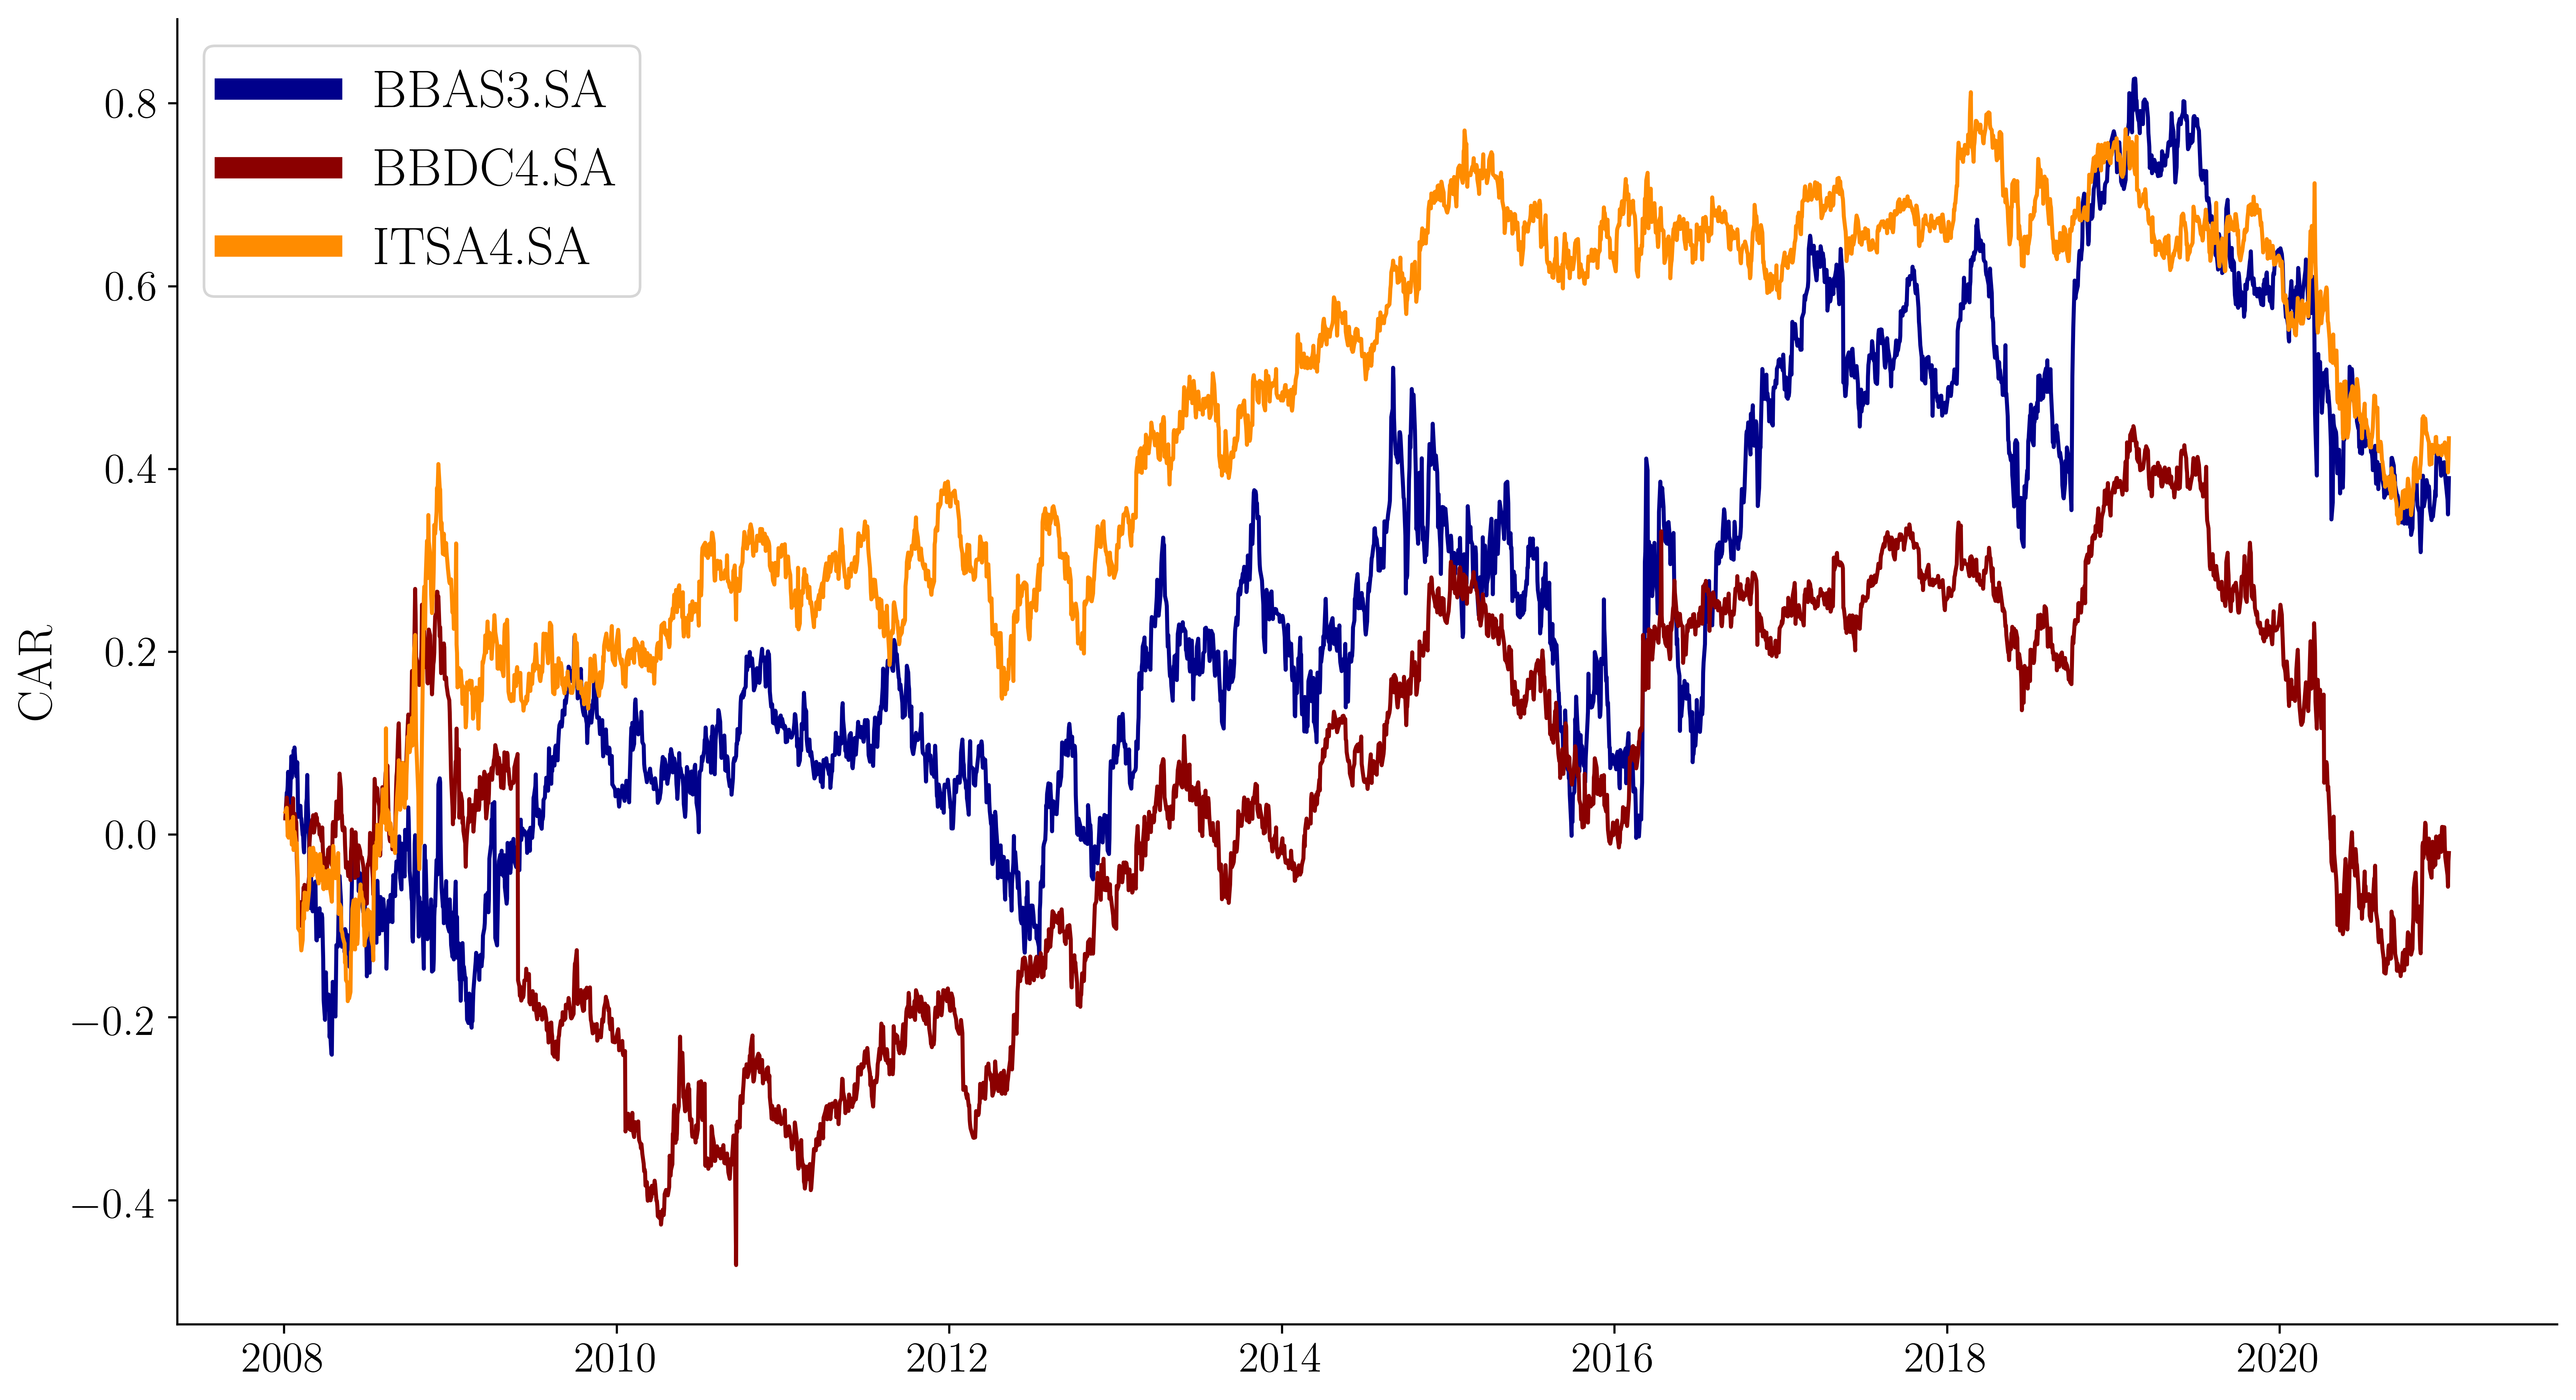

In [29]:
#Coletando dados e plotando
empresas = ['BBAS3.SA', 'BBDC4.SA', 'ITSA4.SA'] #definindo bancos
inicio = '2008-01-03'
fim = '2021-01-08'
dados = m_dados(empresas, inicio, fim, freq='1d')
cores = ['darkblue', 'darkred', 'darkorange']
dados.plot(figsize = [16,10], color = cores);
leg = plt.legend(fontsize=20)
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.ylabel('CAR', fontsize=18);
eixo_seta()
plt.savefig('series_originais.png', 
            dpi=500, 
            bbox_inches='tight',
            pad_inches = 0)

Devido à natureza do mercado acionário o comportamento esperado das instituições de capital aberto ao longo do tempo possui uma tendência de crescimento, apesar algumas oscilações. Isto porque ao observar apenas a série do índice Bovespa, que neste trabalho é o índice de referência de mercado, este mesmo comportamento é observado, como é mostrado na Figura 2.

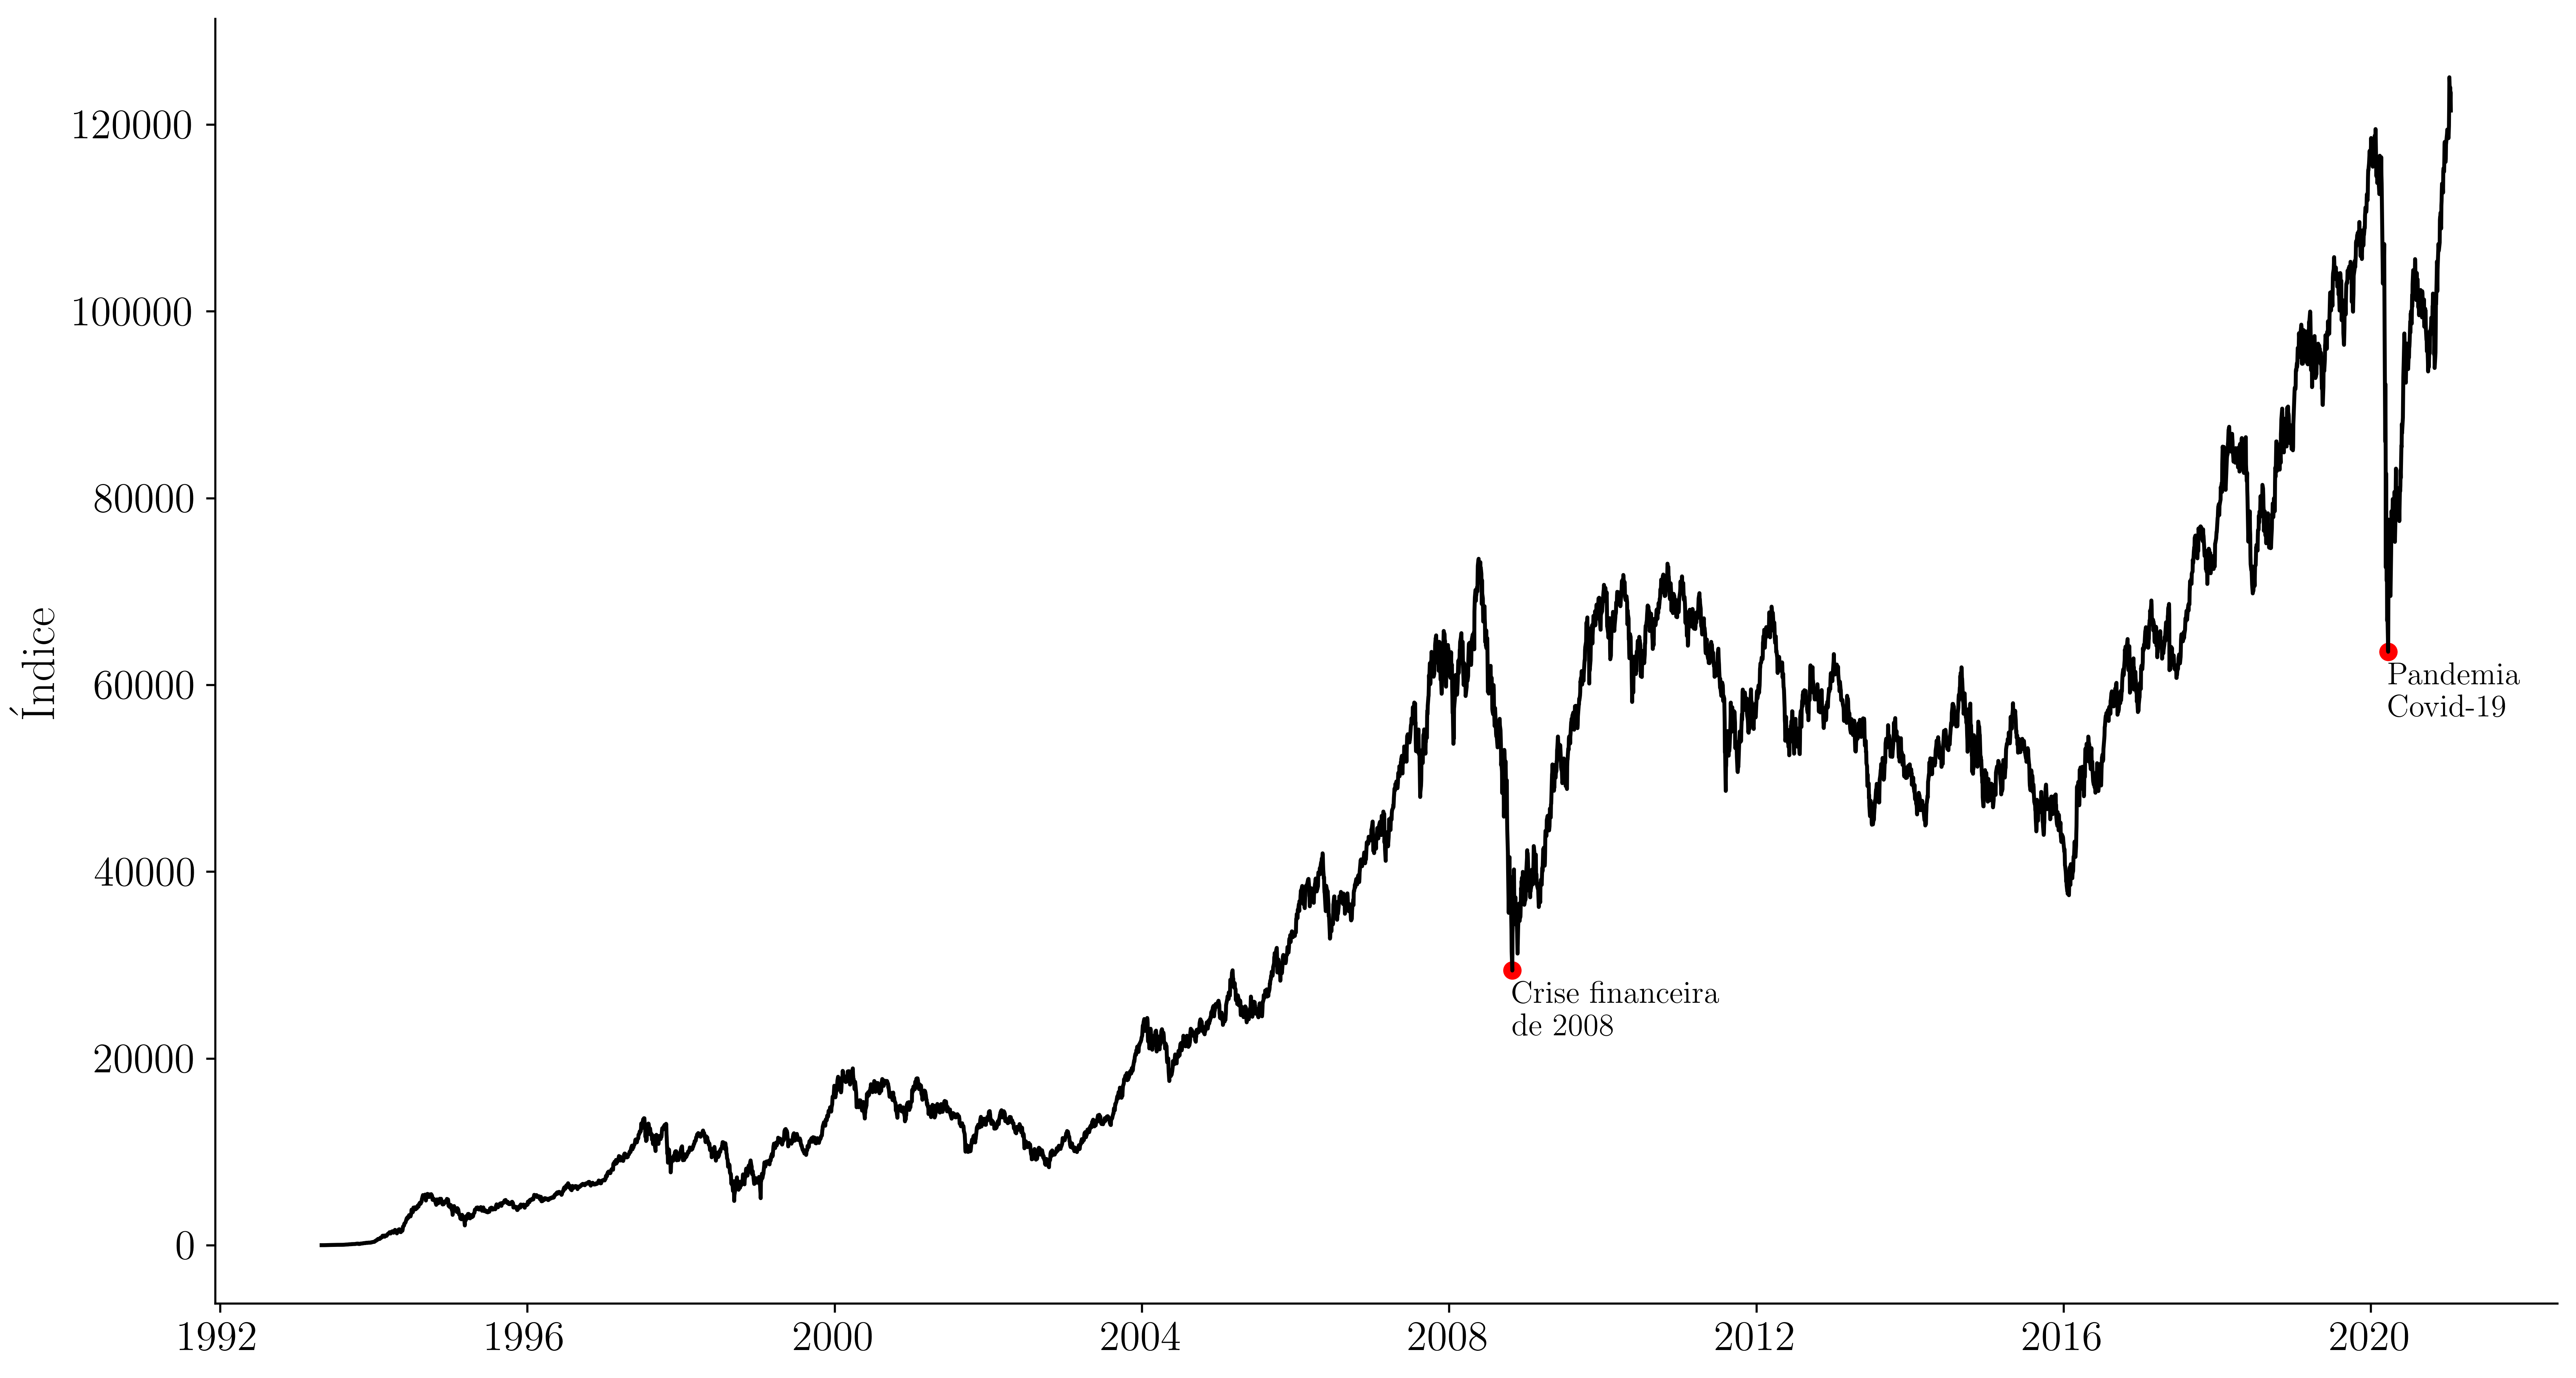

In [38]:
bovespa = yf.download(['^BVSP'] ,period='max', progress=False)['Close'].dropna()
bovespa.plot(figsize = [16,10], label='Bovespa', color='black');
plt.ylabel('Índice', fontsize=18)
plt.xticks(rotation=0, ha = 'center');

bovespa = pd.DataFrame(bovespa)
bovespa['ano'] = pd.DatetimeIndex(bovespa.index).year

menores_x = []
for i in [2008,2020]:
    x = bovespa.groupby('ano').min().loc[i, 'Close']
    filt = (bovespa['Close'] == x)
    x = bovespa[filt].index
    menores_x.append(x)
    
y1 = bovespa.groupby('ano').min().loc[2008, 'Close']
y2 = bovespa.groupby('ano').min().loc[2020, 'Close']
ys = [y1,y2]

#plt.axvline(x = menores_x[0], ls = '--', color= 'red')
#plt.axvline(x = menores_x[1], ls = '--', color= 'red')
plt.scatter(menores_x, ys, color='red', marker='o')
plt.annotate('Crise financeira \n de 2008', (menores_x[0], ys[0]-7000))
plt.annotate('Pandemia \n Covid-19', (menores_x[1], ys[1]-7000))
eixo_seta()
plt.savefig('bovespa.png', dpi=500, 
            bbox_inches='tight',
            pad_inches = 0.1)

In [37]:
# Criando tabela de estatisticas descritivas
medias = np.round(dados.apply(np.mean, axis=0), 4)
variancias = np.round(dados.apply(np.var, axis=0), 4)
erro_padrao = np.round(dados.apply(np.std, axis=0), 4)
minimos = np.round(dados.apply(np.min, axis=0),4)
maximos = np.round(dados.apply(np.max, axis=0),4)
bovespa = bovespa['Close']
bovespa = np.diff(bovespa) / bovespa[:-1] - 1 

media_bov = np.round(np.mean(bovespa), 4)
var_bov = np.round(np.var(bovespa),4)
std_bov = np.round(np.var(bovespa),4)
min_bov = np.round(np.min(bovespa),4)
max_bov = np.round(np.max(bovespa),4)


tabela = pd.concat([minimos, maximos, medias, variancias, erro_padrao], axis=1)
tabela.loc['Bovespa'] = [min_bov, max_bov, media_bov, var_bov, std_bov]
tabela.columns=['Mínimo','Máximo','Média','Variância','Desvio Padrão']
print(tabela.to_latex())
#print(tabela.to_markdown())

\begin{tabular}{lrrrrr}
\toprule
{} &  Mínimo &  Máximo &   Média &  Variância &  Desvio Padrão \\
\midrule
BBAS3.SA & -0.2407 &  0.8273 &  0.2606 &     0.0584 &         0.2417 \\
BBDC4.SA & -0.4709 &  0.4469 &  0.0423 &     0.0463 &         0.2152 \\
ITSA4.SA & -0.1822 &  0.8123 &  0.4538 &     0.0508 &         0.2253 \\
Bovespa  & -1.1581 & -0.6658 & -0.9985 &     0.0005 &         0.0005 \\
\bottomrule
\end{tabular}



Com relação as oscilações no principal índice de mercado brasileiro, existem duas quedas nos índices cujo principal motivo estão evidenciadas no gráfico da Figura 2. Como crises financeiras e doenças pandêmicas são eventos atípicos, é possível que as oscilações causadas por eles tenham algum impacto no modelo a ser ajustado. 
A variabilidade de retorno em cada instituição é um possível indicativo de risco de investimento. Dessa forma, na Tabela 1 são mostradas algumas estatísticas descritivas do retorno de cada série histórica e, em seguida, o gráfico que demostra a variabilidade de cada uma delas (com excessão do índice Bovespa).

|          | Média   | Variância |   Desvio Padrão |
|:---------|--------:|-------:|-------:|
| BBAS3.SA |  0.2606 | 0.0584 | 0.2417 |
| BBDC4.SA |  0.0423 | 0.0463 | 0.2152 |
| ITSA4.SA |  0.4538 | 0.0508 | 0.2253 |
| Bovespa  | -0.9985 | 0.0005 | 0.0005 |

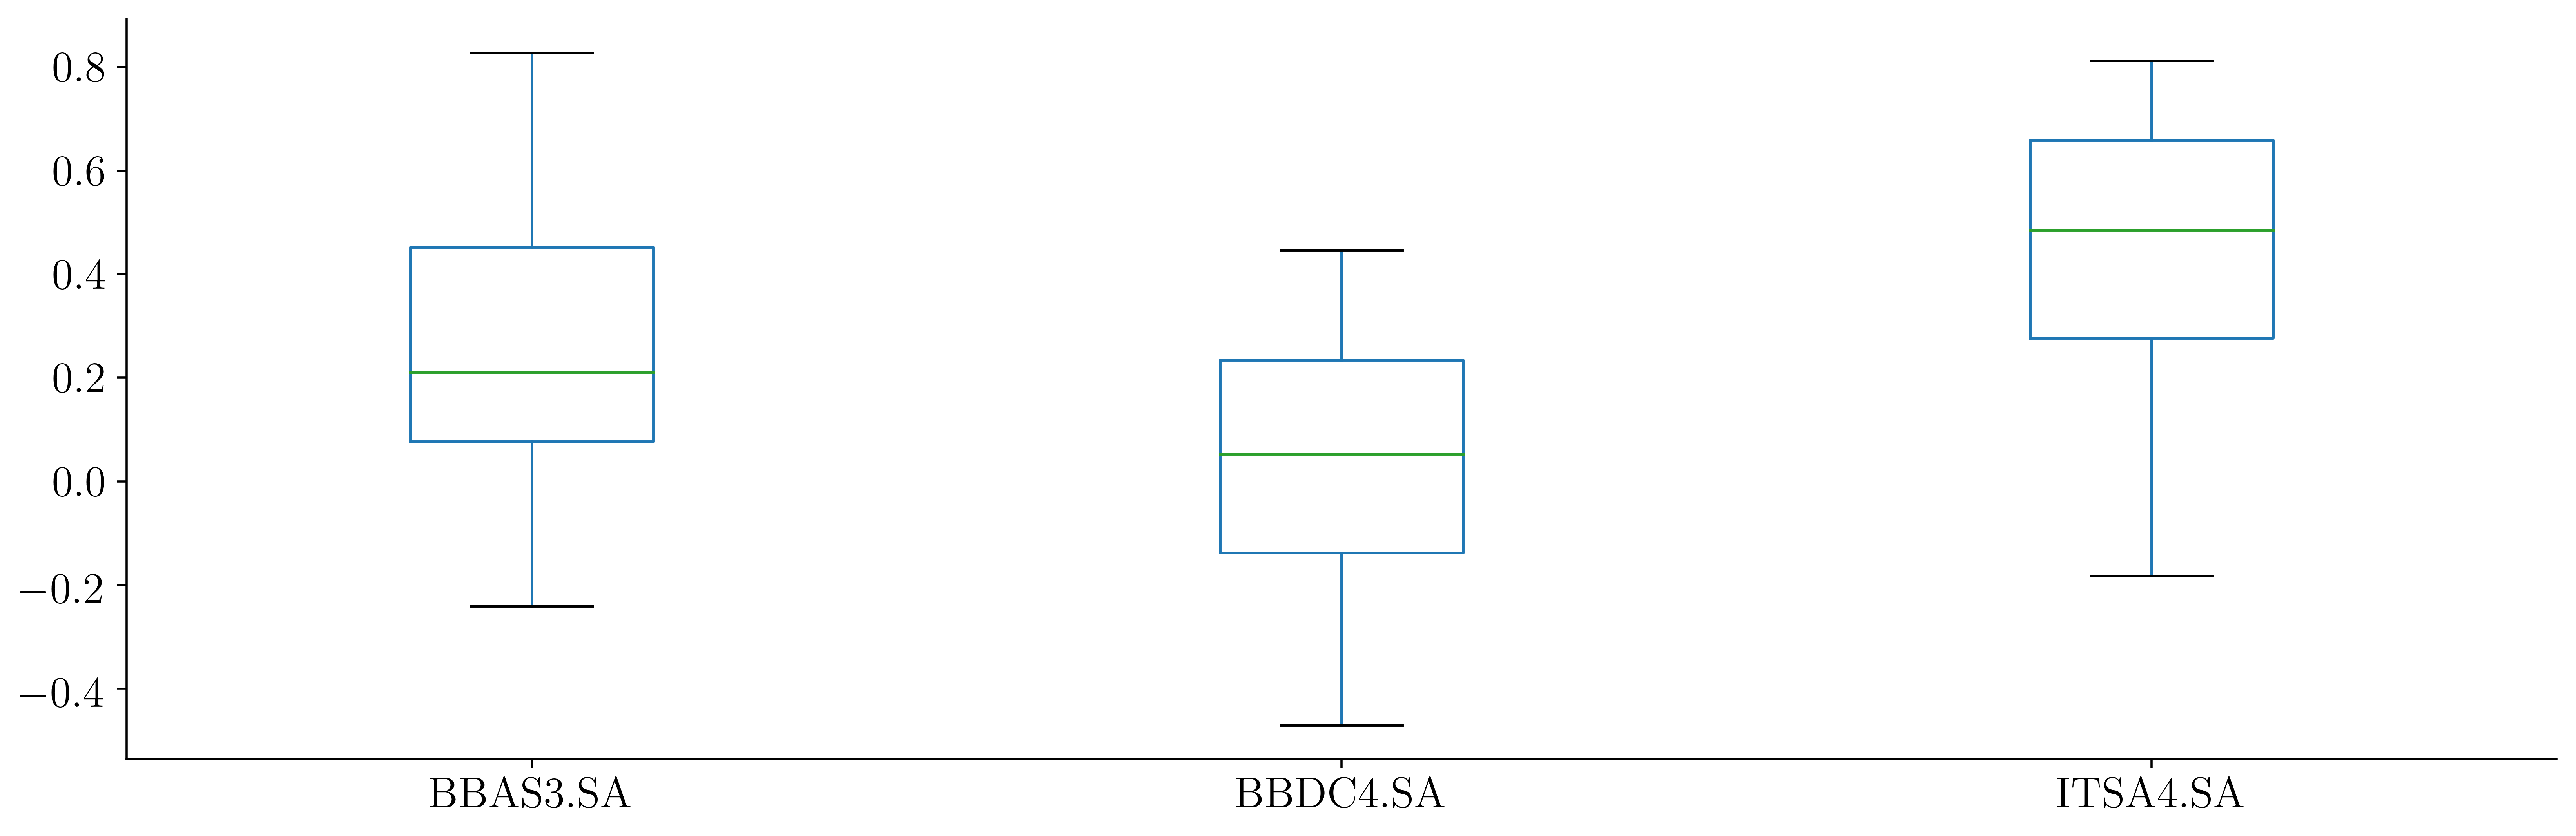

In [5]:
dados.boxplot(figsize=[16,5], grid=False);
eixo_seta()
plt.savefig('boxplots.png', dpi=500, 
            bbox_inches='tight',
            pad_inches = 0)

Dizer que todas as séries variaram em torno de zero significa dizer que todas elas obtiveram, ao longo do tempo, um retorno próximo ao retorno de mercado. Isto implica dizer que os retornos de mercado são um espelho do que acontece com os retornos destas intituições. Essa afirmação faz sentido porque os índices de mercado em geral são calculados a partir dos resultados das empresas que apresentam melhores resultados de governança corporativa. Ou seja, o índice de mercado é uma medida de representativdade da bolsa.


O comportamento de crescimento ao longo do tempo pode ser observado no conjunto de dados disponível das insituições financeiras estudadas neste trabalho. Não exatamente por causa da tendência de crescimento deste mercado, mas principalmente devido a forma de cálculo do retorno anormal acumulado.  

Dessa forma, cabe um estudo do comportamento de tendência em cada uma destas séries a fim de mensurar e remover  tal influência do modelo a ser construído. Por ser uma soma acumulada, é de se esperar que o retorno anormal acumulado observado em uma data $t$ possui dependendência de, no mínimo, da informação observada no instante $t-1$. O gráfico da auto correlação de cada série é mostrado na Figura 3.

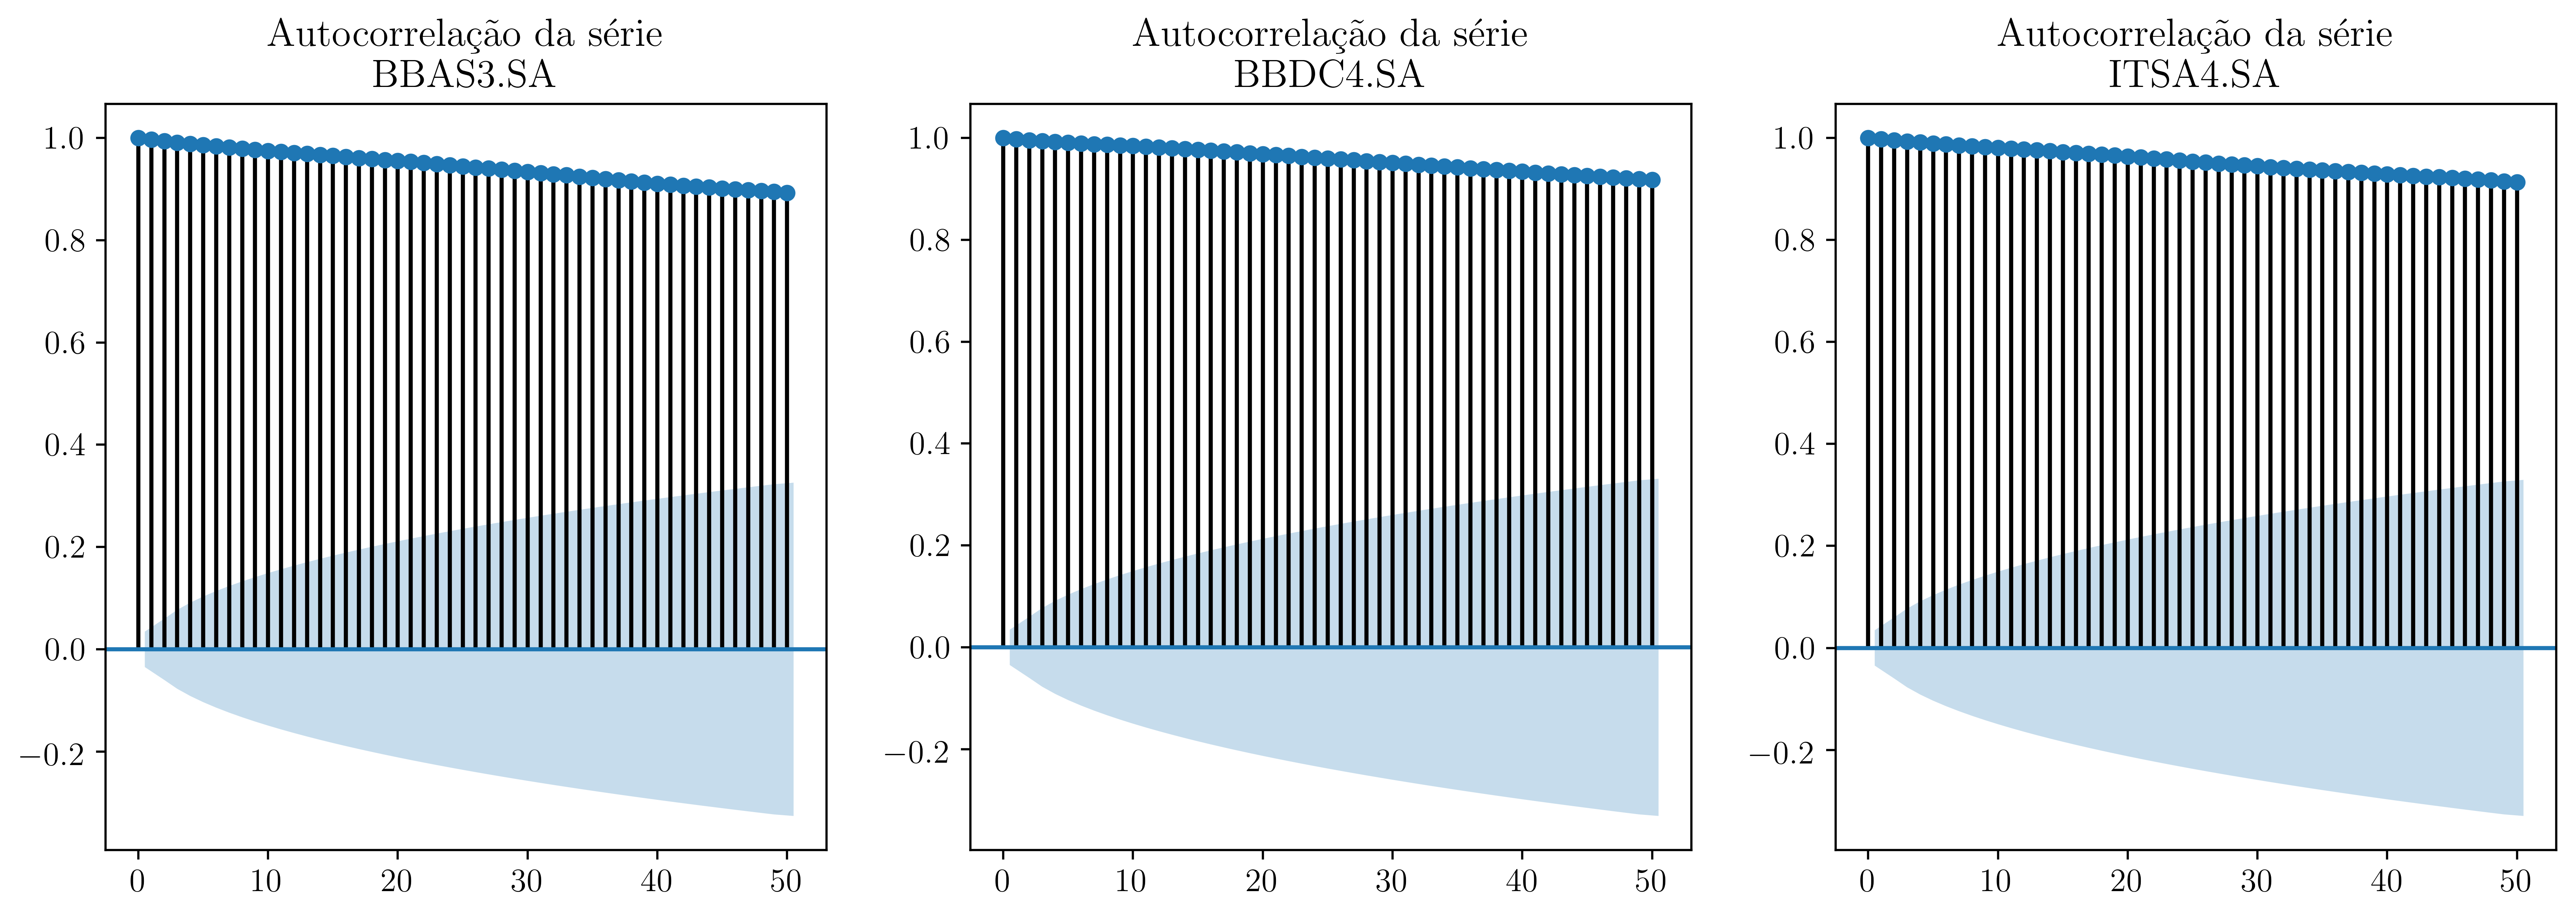

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (16,5))
for i in range(3):
    plot_acf(dados[empresas[i]],  
             ax= ax[i], 
             lags=50,
             title='Autocorrelação da série \n '+ empresas[i])
plt.savefig('acfs_originais.png', 
            dpi=500, 
            bbox_inches='tight',
            pad_inches = 0)

Fazendo a primeira diferença em cada série observa-se que, através do gráfico de autorcorrelação, a componente de tendência foi removida. 

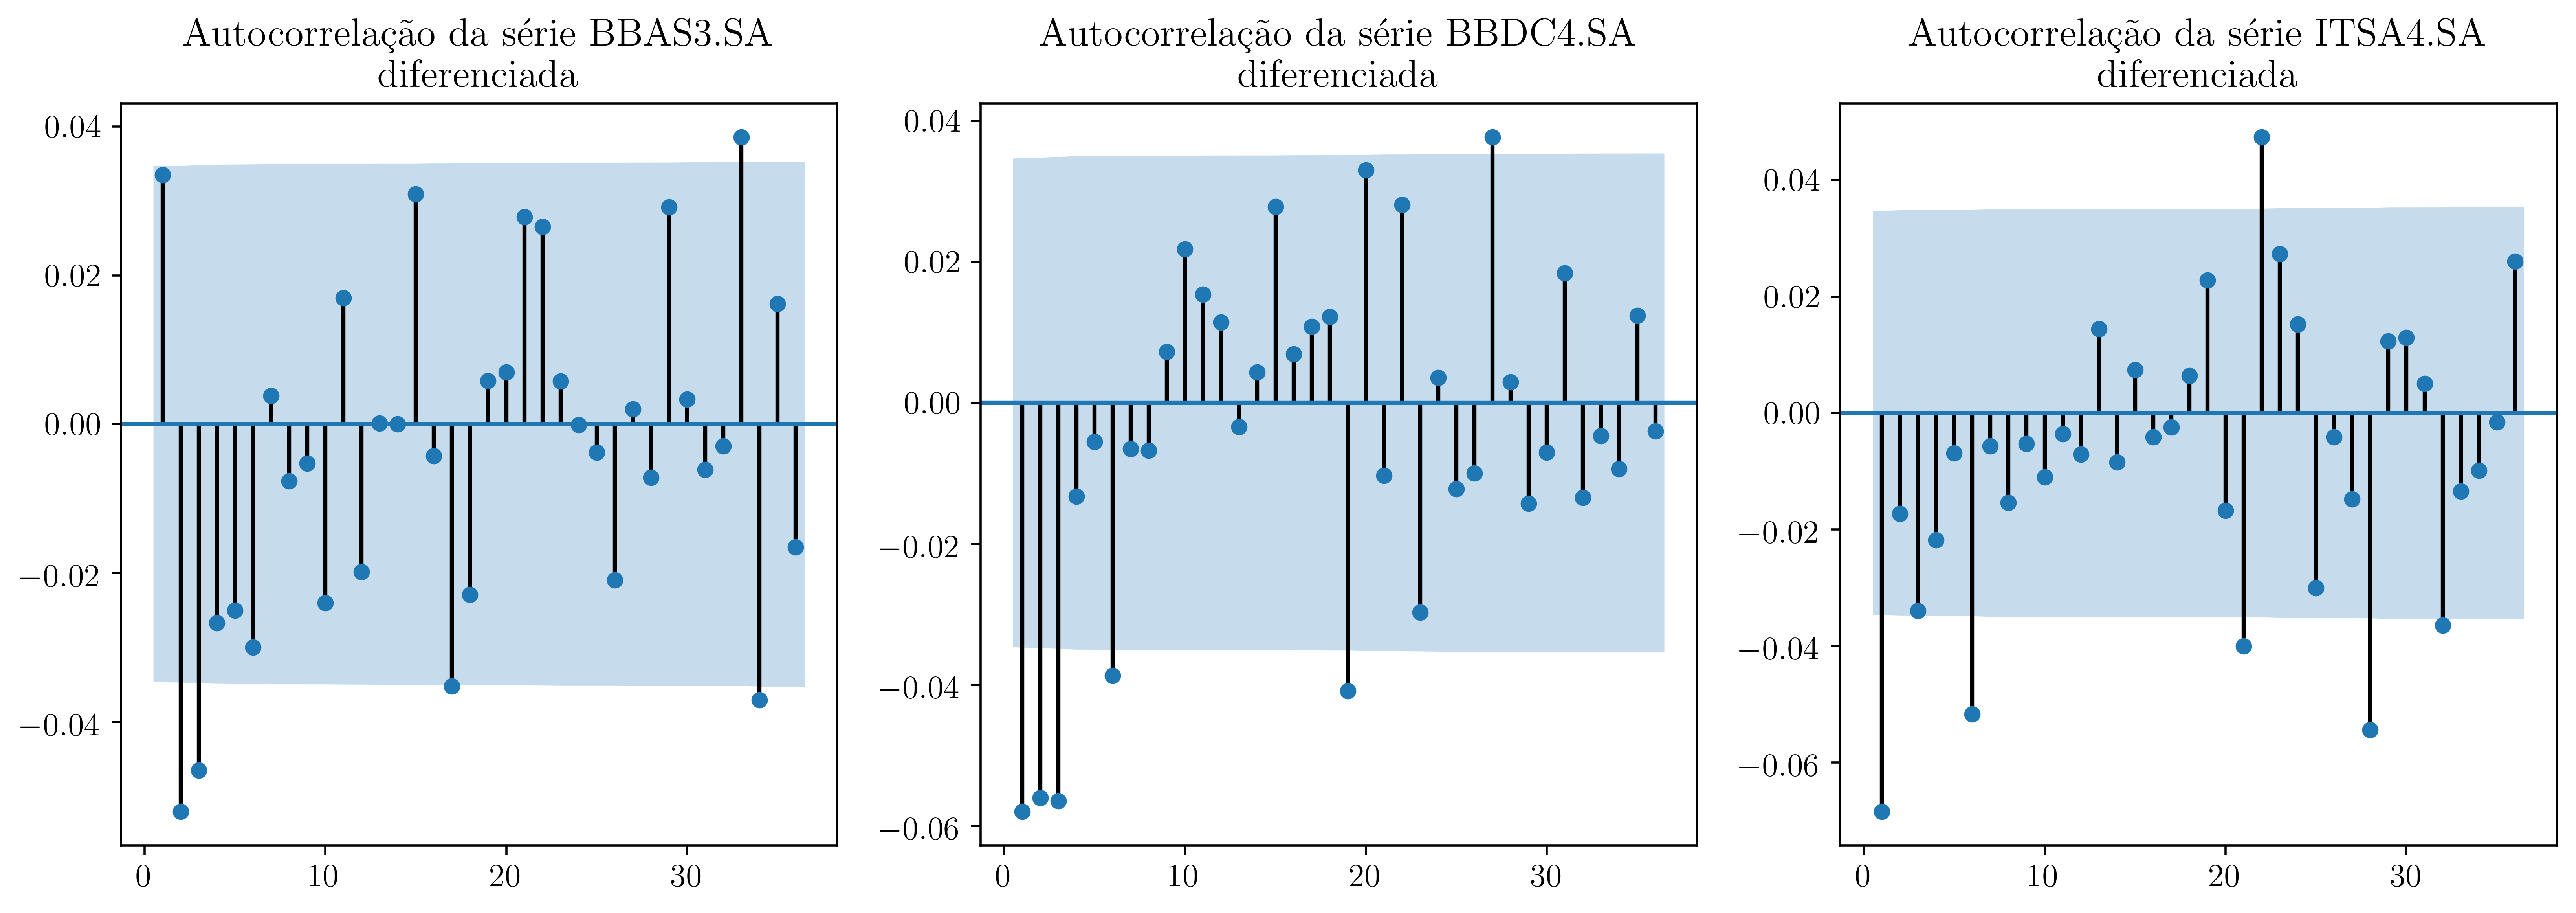

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (16,5))
for i in range(3):
    plot_acf(np.diff(dados[empresas[i]], 1), zero=False,
              ax= ax[i], 
              title='Autocorrelação da série '+ empresas[i]+ ' \n diferenciada')
plt.savefig('acfs_diff1.png',
            dpi=500,
            bbox_inches='tight',
            pad_inches = 0)

A remoção das componentes de tendência e de médias móveis pode ser verificada através do teste de raíz unitária Dickey Fuller aumentado, que apresentou as seguintes estatísticas em cada série diferenciada.

In [8]:
dados_dif = dados.apply(np.diff, axis = 0)

adf_empresa1 = adfuller(dados_dif[empresas[0]], )
adf_empresa2 = adfuller(dados_dif[empresas[1]])
adf_empresa3 = adfuller(dados_dif[empresas[2]])

serie = empresas
ADF = [adf_empresa1[0], adf_empresa2[0], adf_empresa2[0]]
vp = [adf_empresa1[1], adf_empresa2[1], adf_empresa2[1]]

x = pd.DataFrame({'Est. ADF': ADF, 'Valor-p':vp}, index=serie)
print(x.to_latex())

\begin{tabular}{lrr}
\toprule
{} &   Est. ADF &  Valor-p \\
\midrule
BBAS3.SA & -25.590422 &      0.0 \\
BBDC4.SA & -26.248135 &      0.0 \\
ITSA4.SA & -26.248135 &      0.0 \\
\bottomrule
\end{tabular}



|          |   Est. ADF |   Valor-p |
|:---------|-----------:|----------:|
| BBAS3.SA |   -25.5915 |         0 |
| BBDC4.SA |   -26.1931 |         0 |
| ITSA4.SA |   -26.1931 |         0 |

Por estes resultados pode-se afirmar que as séries diferenciadas são estacionárias. Os gráficos de tais séries diferenciadas em ordem um podem ser observadas na Figura 6. Supõe-se, portanto, que a ordem da componente de integração de um modelo ARIMA em série de cada instituição seja 1. Os gráficos das séries estacionárias são mostrados na Figura X.

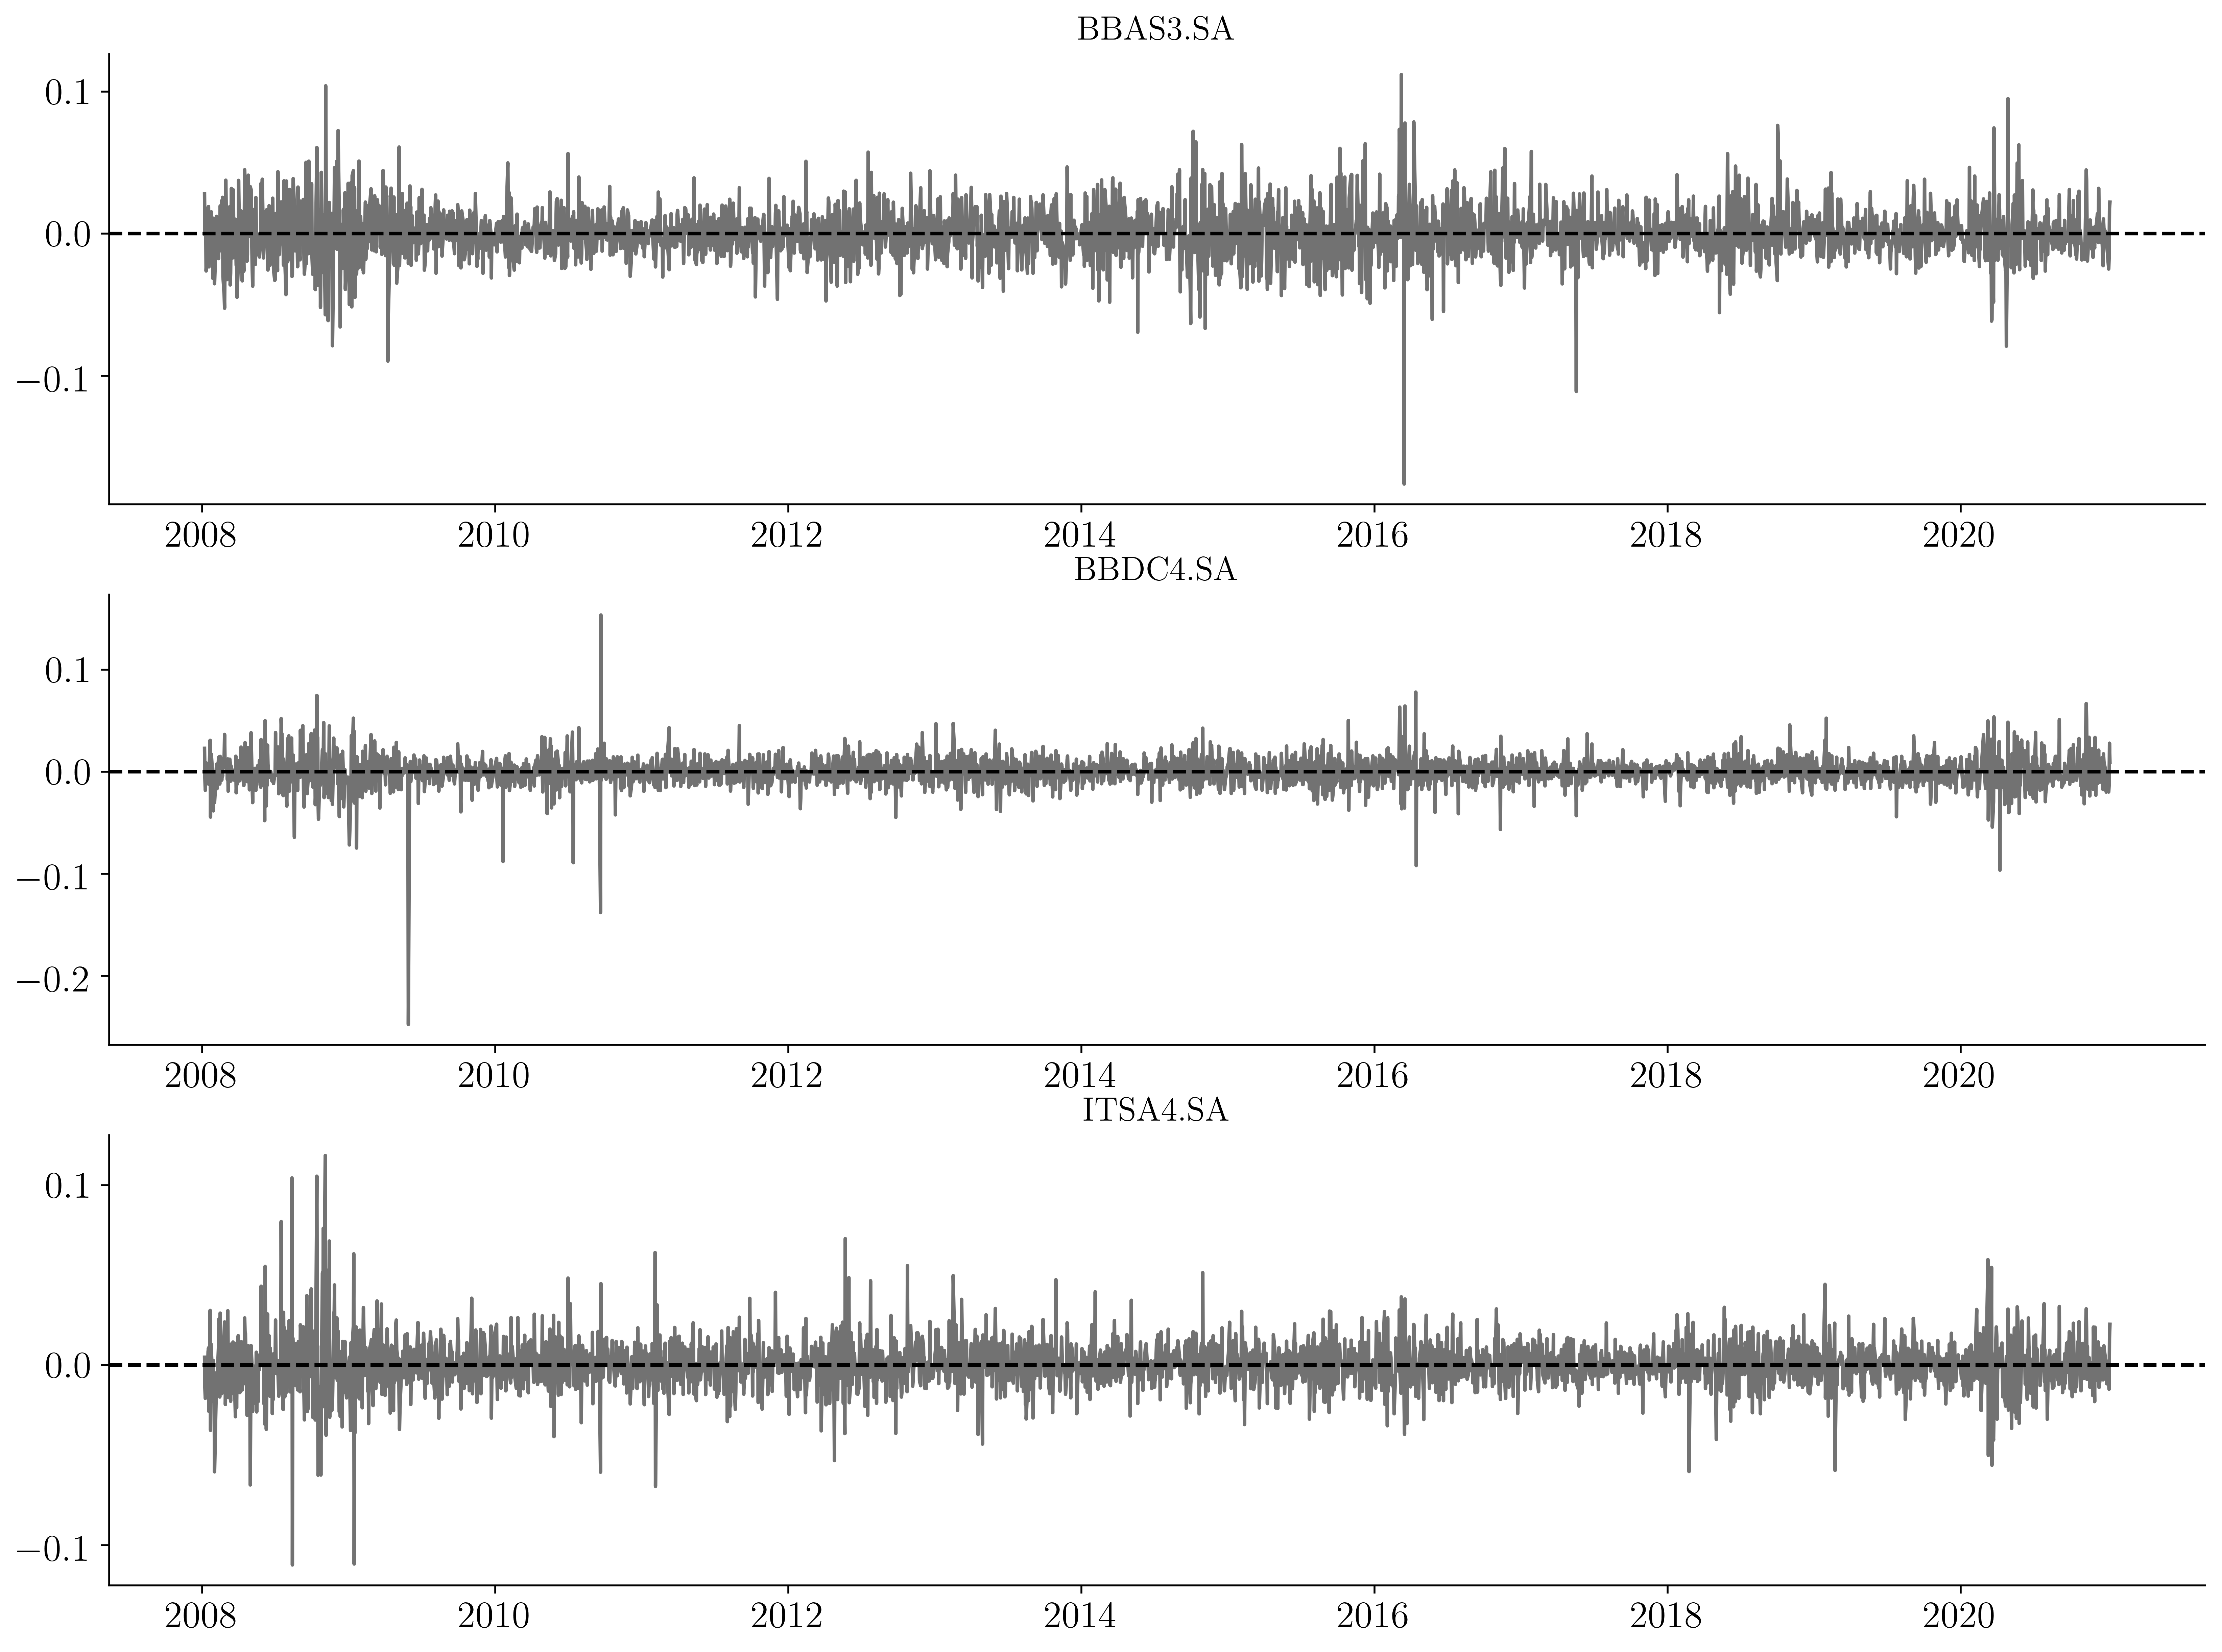

In [9]:
fig, ax = plt.subplots(3,1, figsize=[16,12])
for i in range(3):
    ax[i].plot(dados[empresas[i]].diff(), label=None, color = '#727272');
    eixo_seta()
    ax[i].set_title(empresas[i]);
    ax[i].axhline(y=0, ls='--', color='black')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].tick_params(axis="x", labelsize=16) 
    ax[i].tick_params(axis="y", labelsize=16)
    ax[i].set_xlabel('')
plt.savefig('series_diff1.png', 
            dpi=500, 
            bbox_inches='tight',
            pad_inches = 0)

Entretanto, ainda existe a necessidade de verificar a existência da componente auto regressiva e de médias móveis e, dada a fórmula de cálculo do retorno anormal acumulado, é possível que tal componente tenha impacto signficativo no modelo final. Para uma primeira análise, são mostradas na Figura X os gráficos de autocorrelação e autocorrelação parcial de cada série.

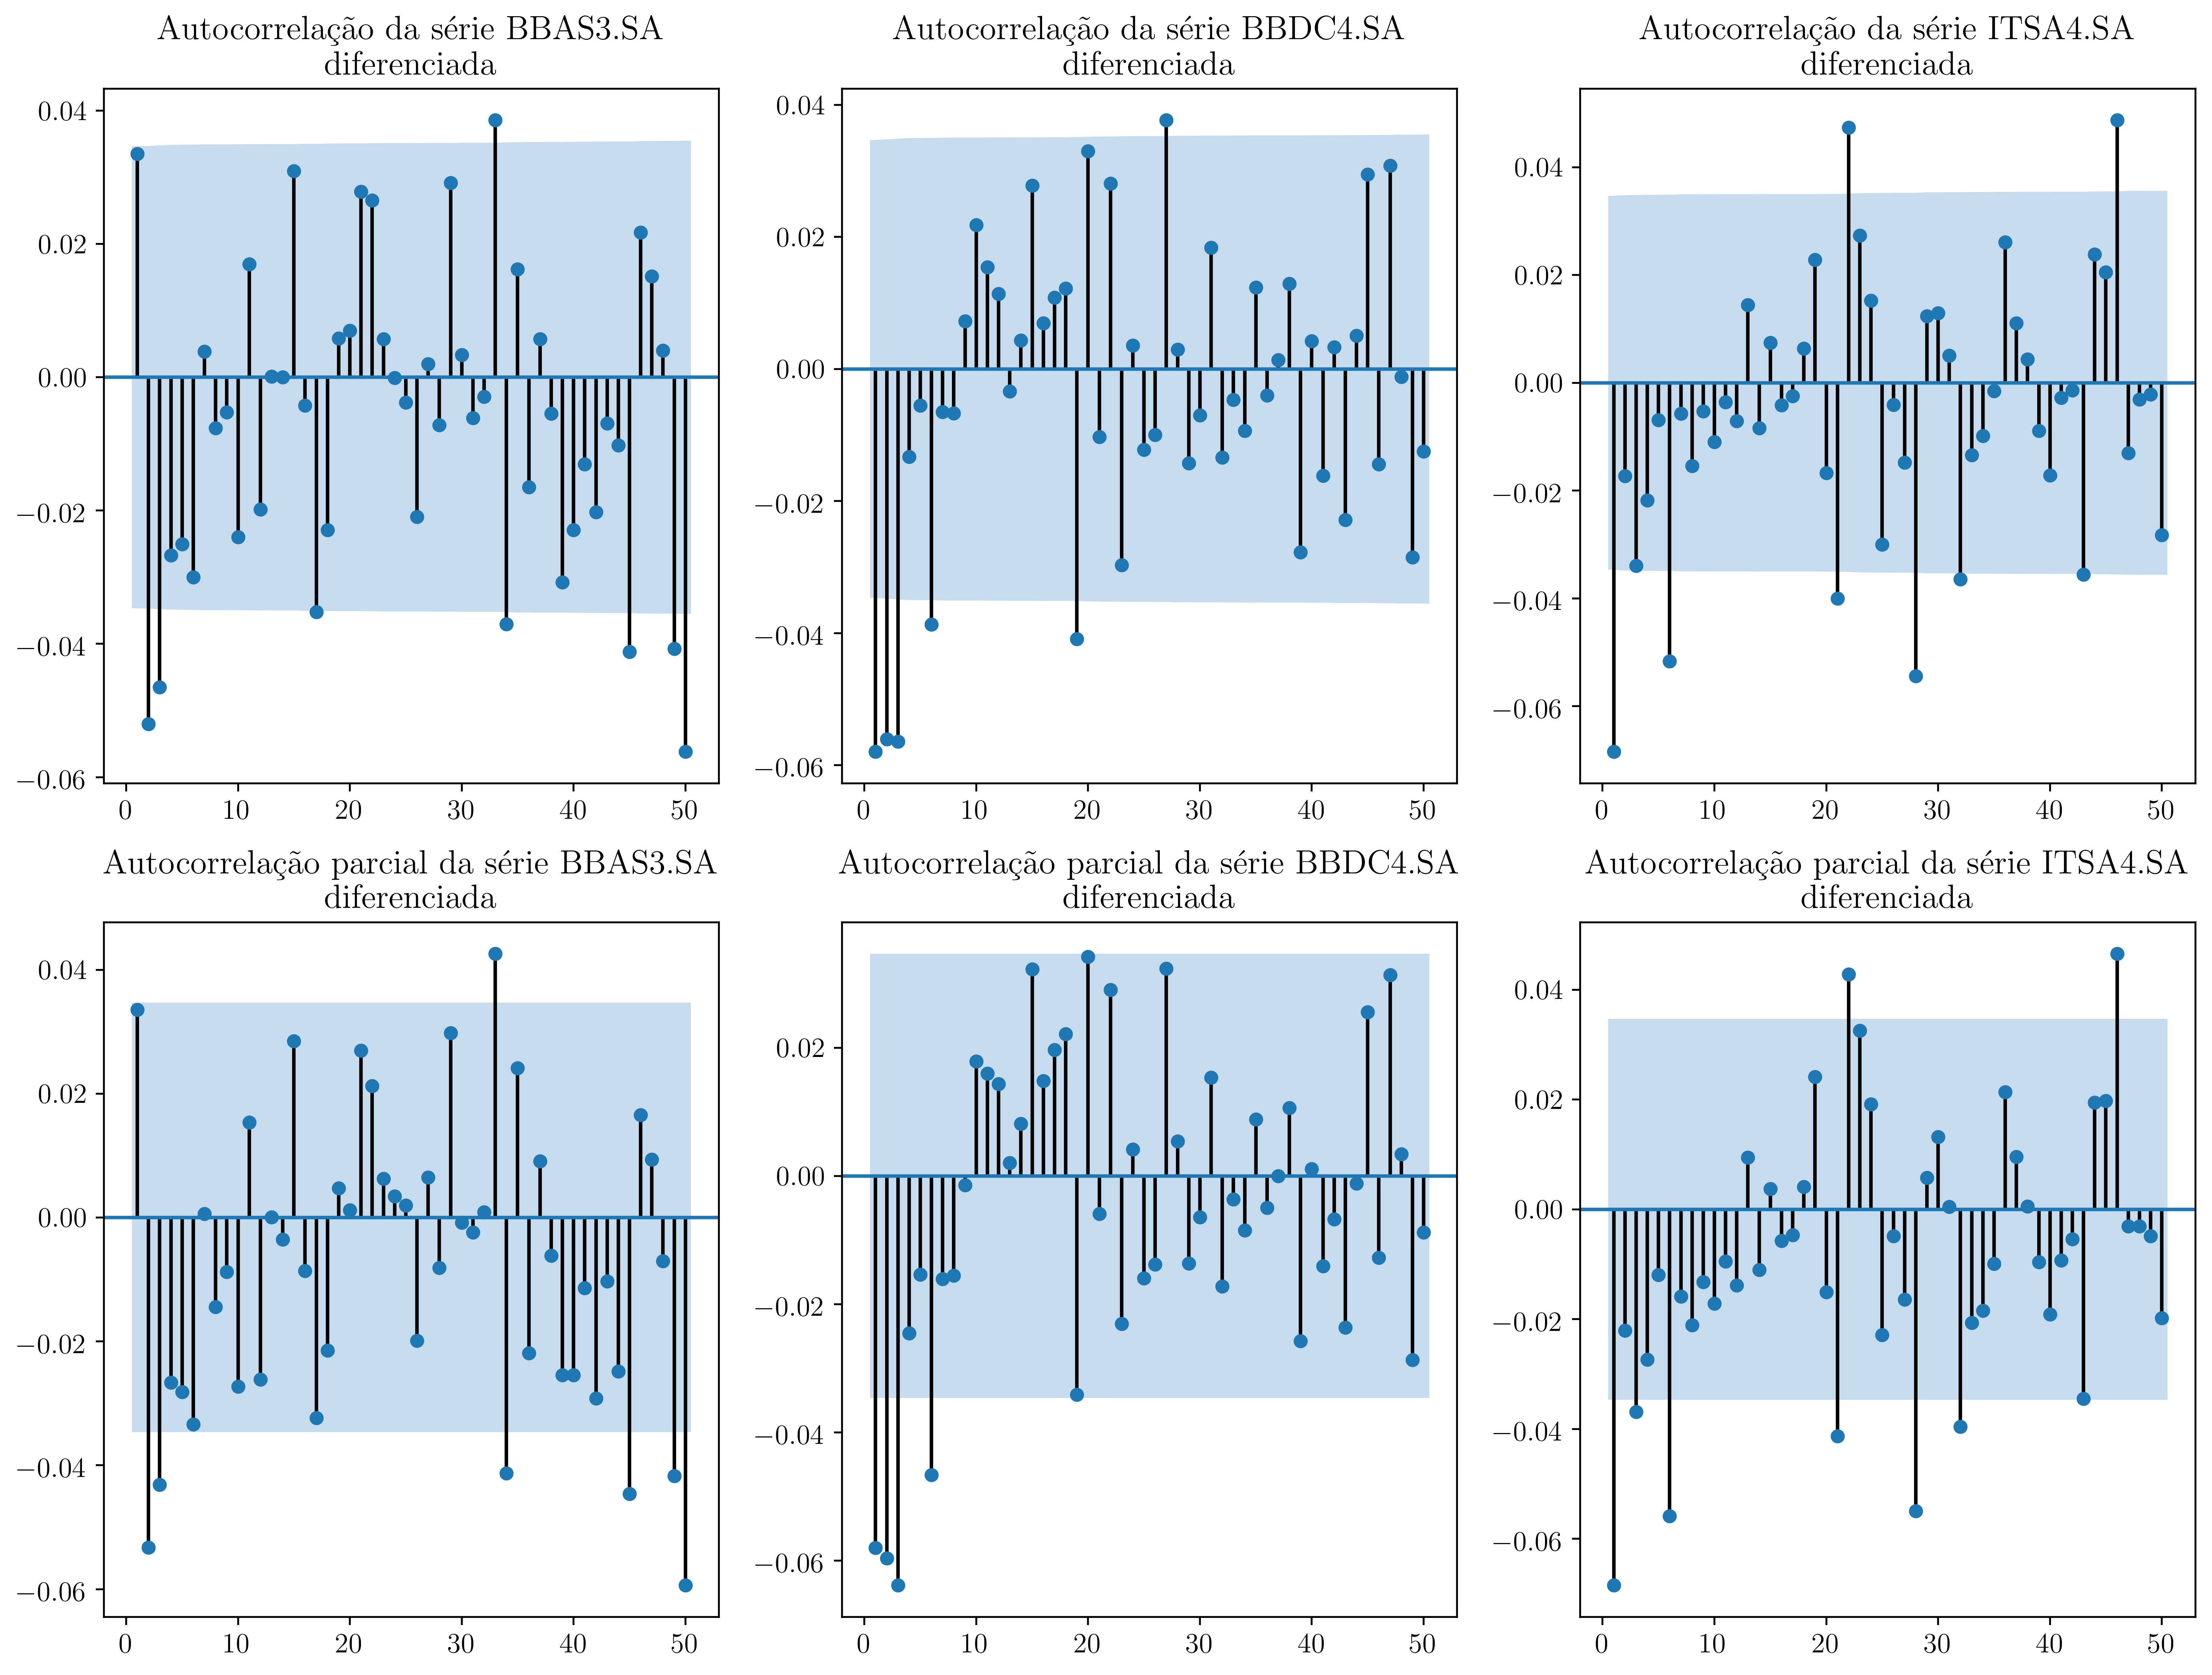

In [10]:
fig, ax = plt.subplots(2, 3, figsize = (16,12))
for j in range(3):
    plot_acf(np.diff(dados[empresas[j]]),
              zero=False,
              lags=50,
              ax= ax[0,j], 
              title='Autocorrelação da série '+ empresas[j] + '\n diferenciada')
    plot_pacf(np.diff(dados[empresas[j]], 1),
              zero=False,
              lags=50,
              ax= ax[1,j], 
              title='Autocorrelação parcial da série '+ empresas[j] + '\n diferenciada')
plt.savefig('pacf_diff1.png', 
            dpi=500, 
            bbox_inches='tight',
            pad_inches = 0)

A partir destas condições, para cada série foram sugeridos dois modelos:

| Série     | Modelo 1     | Modelo 2     |
|-----------|--------------|--------------|
| BBASA3.SA | AR(1)        | ARIMA(0,1,0) |
| BBDC4.SA  | ARMA(1,1)    | ARIMA(1,1,1) |
| ITSA4.SA  | ARMA(1,1)    | ARIMA(1,1,1) |

Duas métricas foram escolhidas para selecionar o melhor modelo em cada série: o erro quadrático médio e o critério de Akaique.


In [11]:
dados.index = pd.DatetimeIndex(dados.index).to_period('D')

In [12]:
###AJUSTANDO ARIMA(1,0,0)-------------

m1_empresa_1 = ARIMA(dados[empresas[0]], order=(1,0,0)).fit()
m1_empresa_2 = ARIMA(dados[empresas[1]], order=(1,0,1)).fit()
m1_empresa_3 = ARIMA(dados[empresas[2]], order=(1,0,1)).fit()

###AJUSTANDO ARIMA(1,0,1)---------
m2_empresa_1 = ARIMA(dados[empresas[0]], order=(0,1,0)).fit()
m2_empresa_2 = ARIMA(dados[empresas[1]], order=(1,1,1)).fit()
m2_empresa_3 = ARIMA(dados[empresas[2]], order=(1,1,1)).fit()


###COLHENDO EQMS-------
previsoes_m1 = pd.concat([m1_empresa_1.fittedvalues, 
                          m1_empresa_2.fittedvalues,
                          m1_empresa_3.fittedvalues], axis=1)

previsoes_m2 = pd.concat([m2_empresa_1.fittedvalues, 
                          m2_empresa_2.fittedvalues,
                          m2_empresa_3.fittedvalues], axis=1)

previsoes_m1.columns = empresas
previsoes_m2.columns = empresas


def eqm(x,y):
    return np.mean((x-y)**2)

EQMS_m1 = []
EQMS_m2 = []

for i in empresas:
    x = eqm(dados[i], previsoes_m1[i])
    y = eqm(dados[i], previsoes_m2[i])
    EQMS_m1.append(x)
    EQMS_m2.append(y)

###COLHENDO AICS-------
AICS_M1 = [m1_empresa_1.aic, m1_empresa_2.aic, m1_empresa_3.aic]
AICS_M2 = [m2_empresa_1.aic, m2_empresa_2.aic, m2_empresa_3.aic]


selecao = pd.DataFrame({'Série':empresas,
                        'AIC Modelo 1':AICS_M1,
                        'AIC Modelo 2':AICS_M2,
                        'EQM Modelo 1':EQMS_m1,
                        'EQM Modelo 2':EQMS_m2})

selecao.set_index('Série', inplace=True)
#print(selecao.to_markdown())


| Série    |   AIC Modelo 1 |   AIC Modelo 2 |   EQM Modelo 1 |   EQM Modelo 2 |
|:---------|---------------:|---------------:|---------------:|---------------:|
| BBAS3.SA |       -16519.7 |       -16516.9 |    0.000349981 |      0.126298  |
| BBDC4.SA |       -17871.1 |       -17892.6 |    0.000218246 |      0.0481656 |
| ITSA4.SA |       -18328.1 |       -18341.3 |    0.000229521 |      0.256684  |

De acordo com as informações da Tabela, para a série da empresa BBAS3.SA o melhor modelo segundo critério de Akaique foi o modelo 1 *ARIMA(1,0,0)*. Para as empresas BBDC4.SA e ITSA4.SA o segundos modelos apresentaram menores critérios de Akaique. Entretanto, como o objetivo principal é a previsão do CAR, o critério decisivo será o menor erro quadrático médio e, por isso, em todas as séries os primeiros modelos obtiveram melhores resultados. Sendo assim, os modelos escolhidos para as séries BBAS3.SA, BBDC4.SA e ITSA4.SA são, respectivamente, *ARIMA(1,0,0)*, *ARIMA(1,0,1)* e *ARIMA(1,0,1)*. Na Figura 7 é mostrada a comparação das últimas 50 observações de cada série original com seus respectivos valores preditos pelo modelo ARIMA(1,0,1).

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


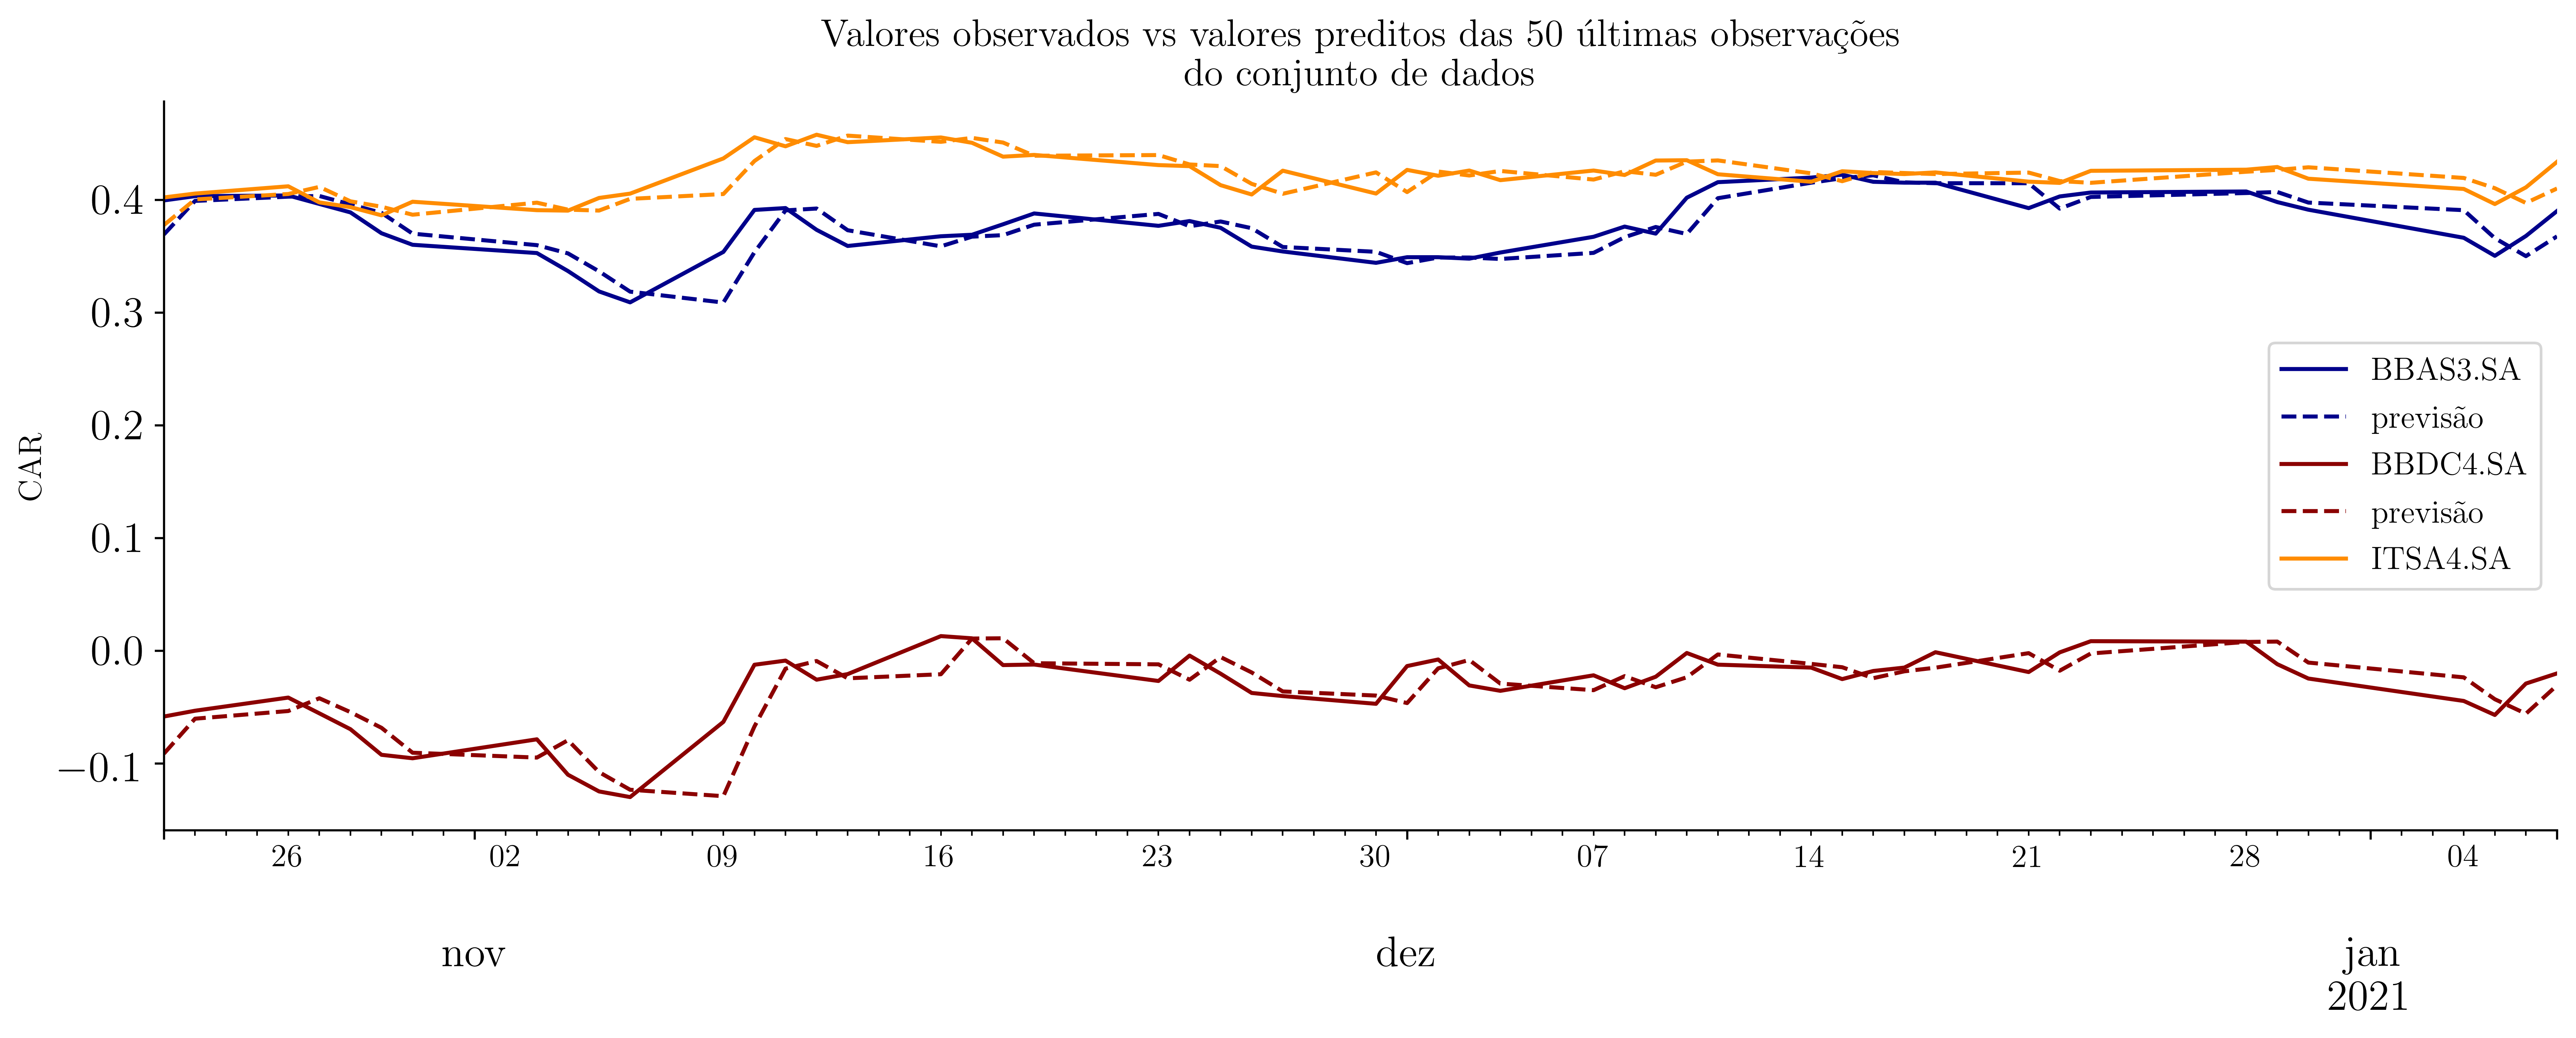

In [13]:
previsoes_escolhidas = pd.DataFrame({empresas[0]:previsoes_m1[empresas[0]],
                                     empresas[1]:previsoes_m1[empresas[1]],
                                     empresas[2]:previsoes_m1[empresas[2]]})


for i in range(3):
    dados[empresas[i]][-50:].plot(figsize=[16,5], color=cores[i], label=empresas[i]);
    plt.legend();
    plt.plot(previsoes_escolhidas.iloc[-50:, i], ls='--', color=cores[i], label='previsão');
plt.title('Valores observados vs valores preditos das 50 últimas observações \n do  conjunto de dados')
plt.ylabel('CAR')
eixo_seta()
plt.savefig('ajustes.png', 
            dpi=500,
            bbox_inches='tight',
            pad_inches = 0)

Na Figura 8 são mostradas as séries originais com seus respectivos intervalos de confiança gerados pelos modelos escolhidos.

In [14]:
vetor_datas = m_dados(empresas, inicio, fim, freq='1d').index
dados.index = vetor_datas

conf_0 = m1_empresa_1.conf_int(alpha=.05)
conf_1 = m1_empresa_2.conf_int(alpha=.05)
conf_2 = m1_empresa_3.conf_int(alpha=.05)

previsoes_escolhidas['inf_BBAS3.SA'] = previsoes_escolhidas['BBAS3.SA'] - conf_0.iloc[1,0]
previsoes_escolhidas['sup_BBAS3.SA'] = previsoes_escolhidas['BBAS3.SA'] + conf_0.iloc[1,1]

previsoes_escolhidas['inf_BBDC4.SA'] = previsoes_escolhidas['BBDC4.SA'] - conf_1.iloc[1,0]
previsoes_escolhidas['sup_BBDC4.SA'] = previsoes_escolhidas['BBDC4.SA'] + conf_1.iloc[1,1]

previsoes_escolhidas['inf_ITSA4.SA'] = previsoes_escolhidas['ITSA4.SA'] - conf_2.iloc[1,0]
previsoes_escolhidas['sup_ITSA4.SA'] = previsoes_escolhidas['ITSA4.SA'] + conf_2.iloc[1,1]

previsoes_escolhidas.index = dados.index

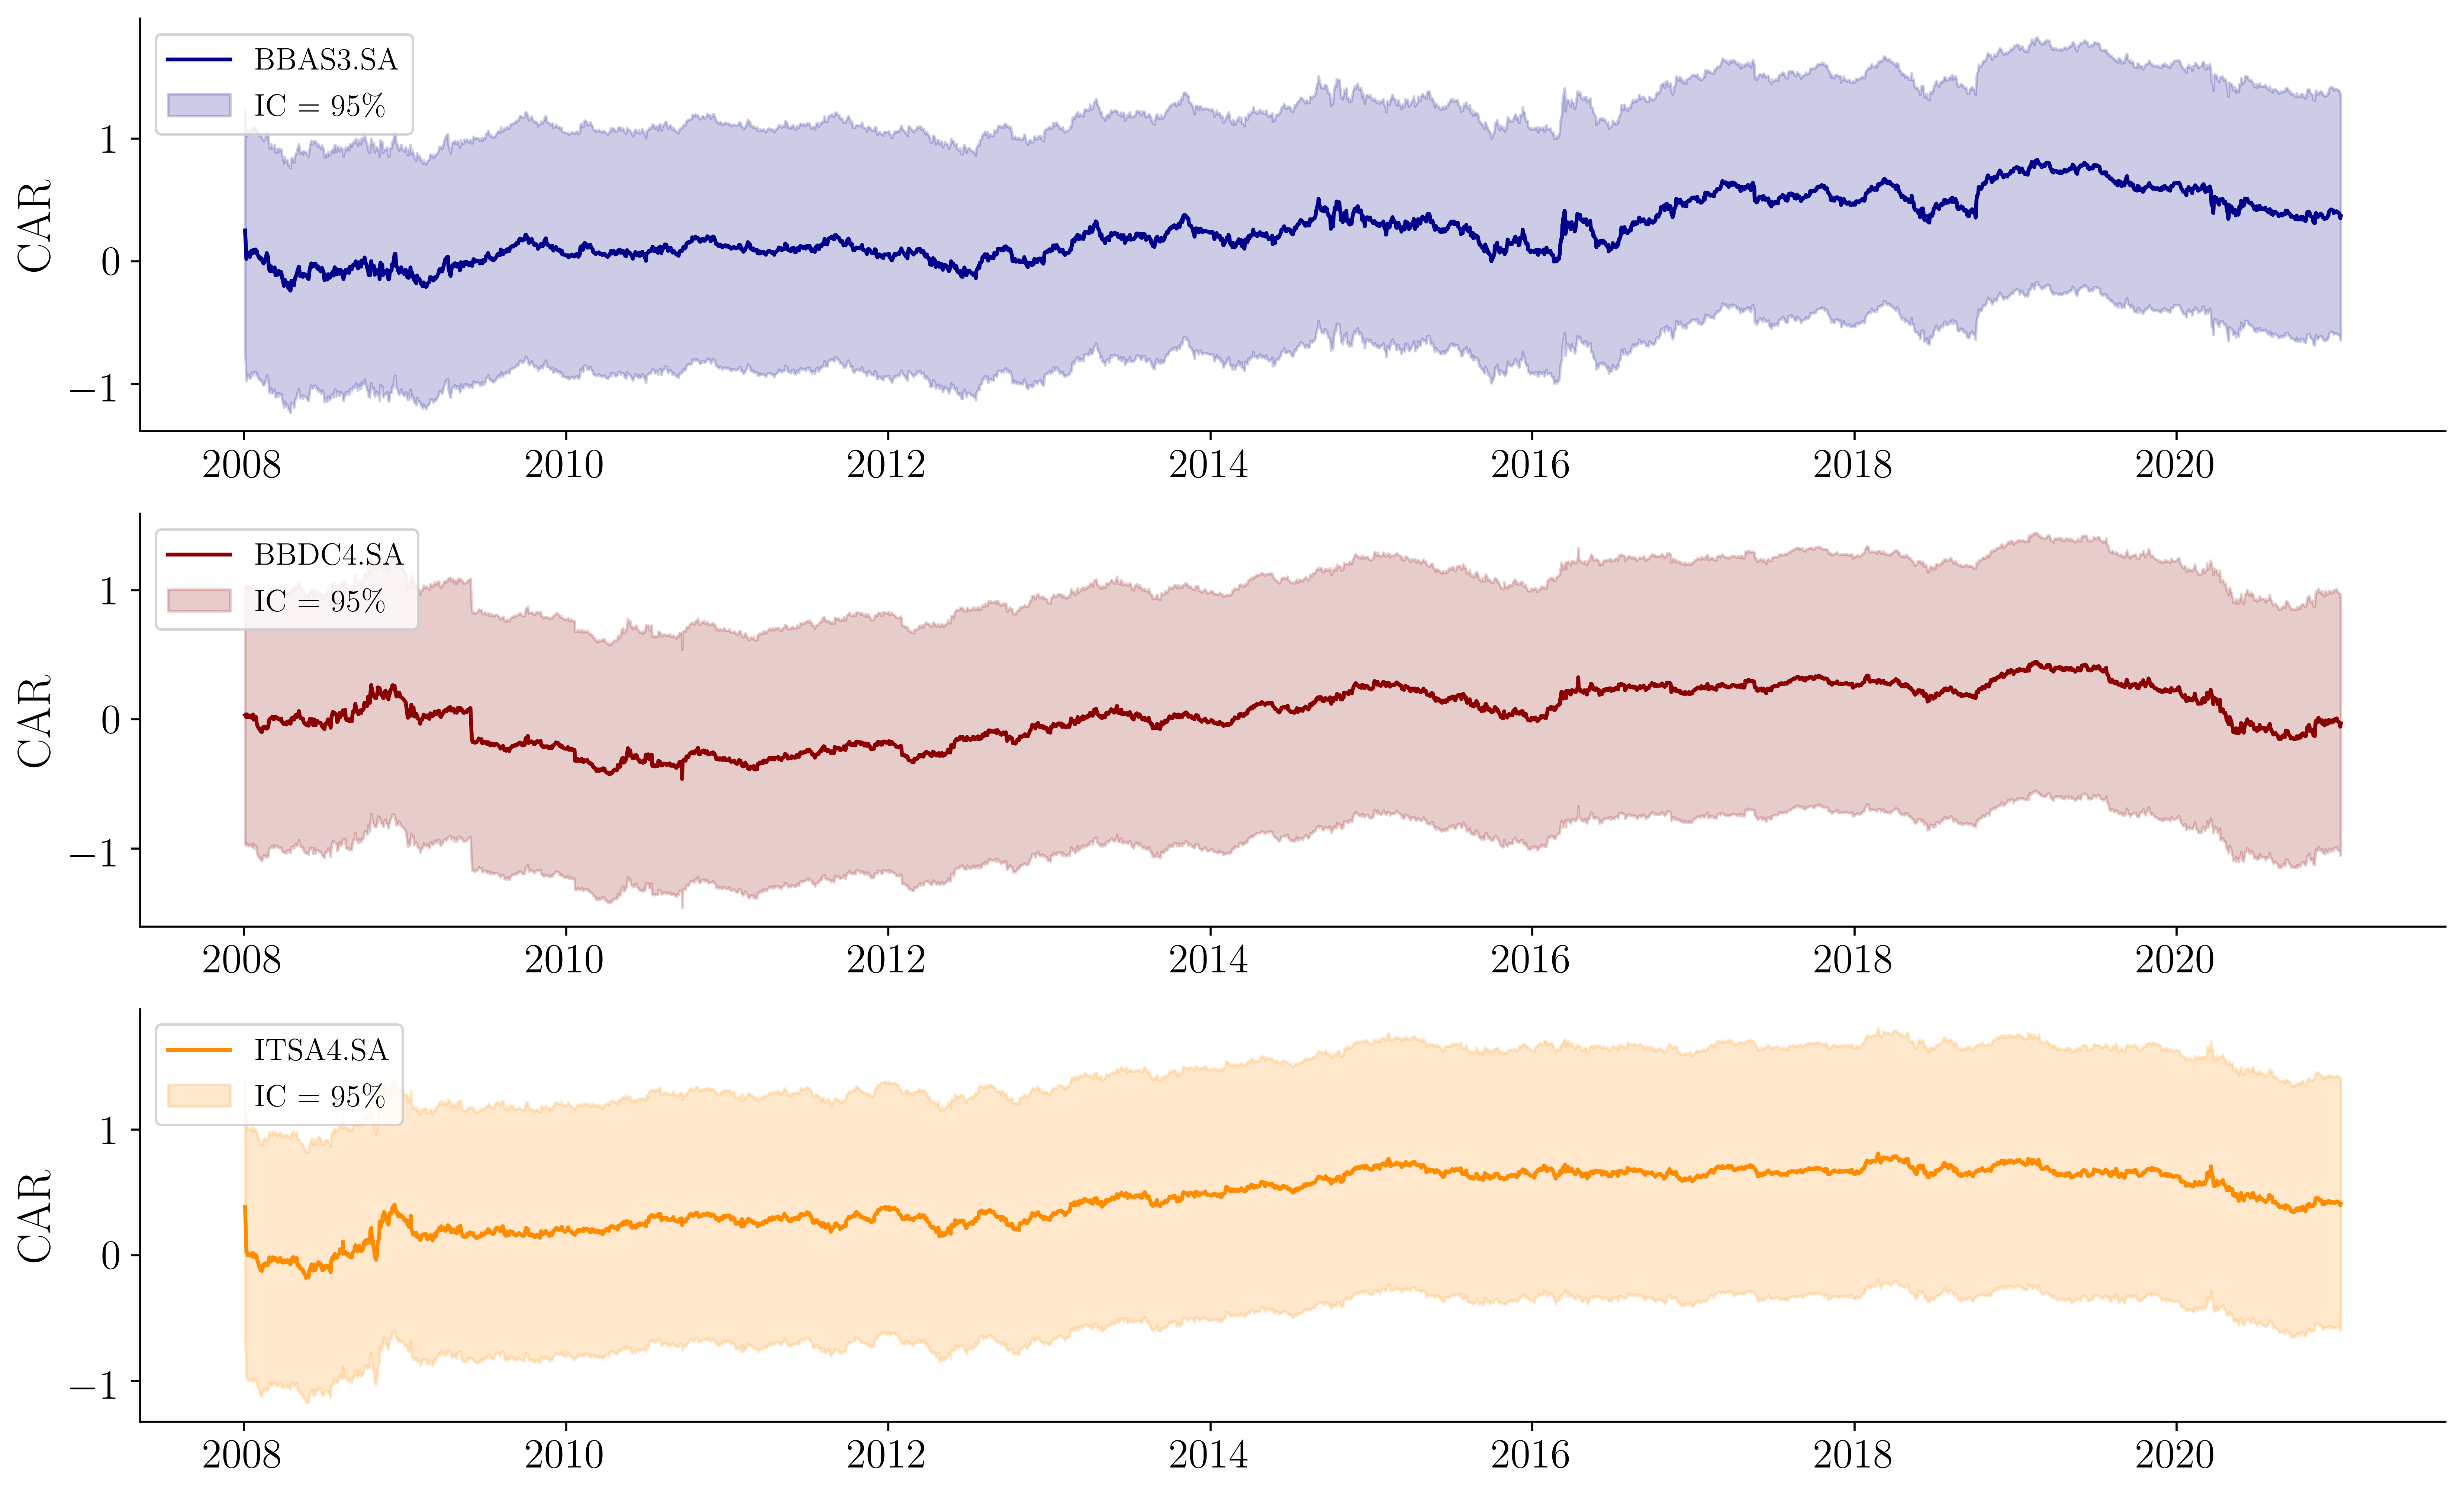

In [15]:
infs = ['inf_BBAS3.SA','inf_BBDC4.SA','inf_ITSA4.SA']
sups = ['sup_BBAS3.SA', 'sup_BBDC4.SA', 'sup_ITSA4.SA']

fig, ax = plt.subplots(3,1, figsize=[16,10])

for i in range(3):
    ax[i].plot(previsoes_escolhidas[empresas[i]], color = cores[i], label=empresas[i])
    ax[i].fill_between(previsoes_escolhidas.index, 
                       previsoes_escolhidas[infs[i]], 
                       previsoes_escolhidas[sups[i]], 
                       color = cores[i], 
                       alpha=.2, 
                       label='IC = 95\%')
    ax[i].legend(loc='upper left')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylabel('CAR', fontsize=18)
    ax[i].tick_params(axis="x", labelsize=16) 
    ax[i].tick_params(axis="y", labelsize=16)
    ax[i].set_xlabel('')
plt.savefig('ICs.png',
            dpi=500, 
            bbox_inches='tight',
            pad_inches = 0)

No gráfico da Figura 9 é mostrado valores de previsão e valor da amostra separados para teste.

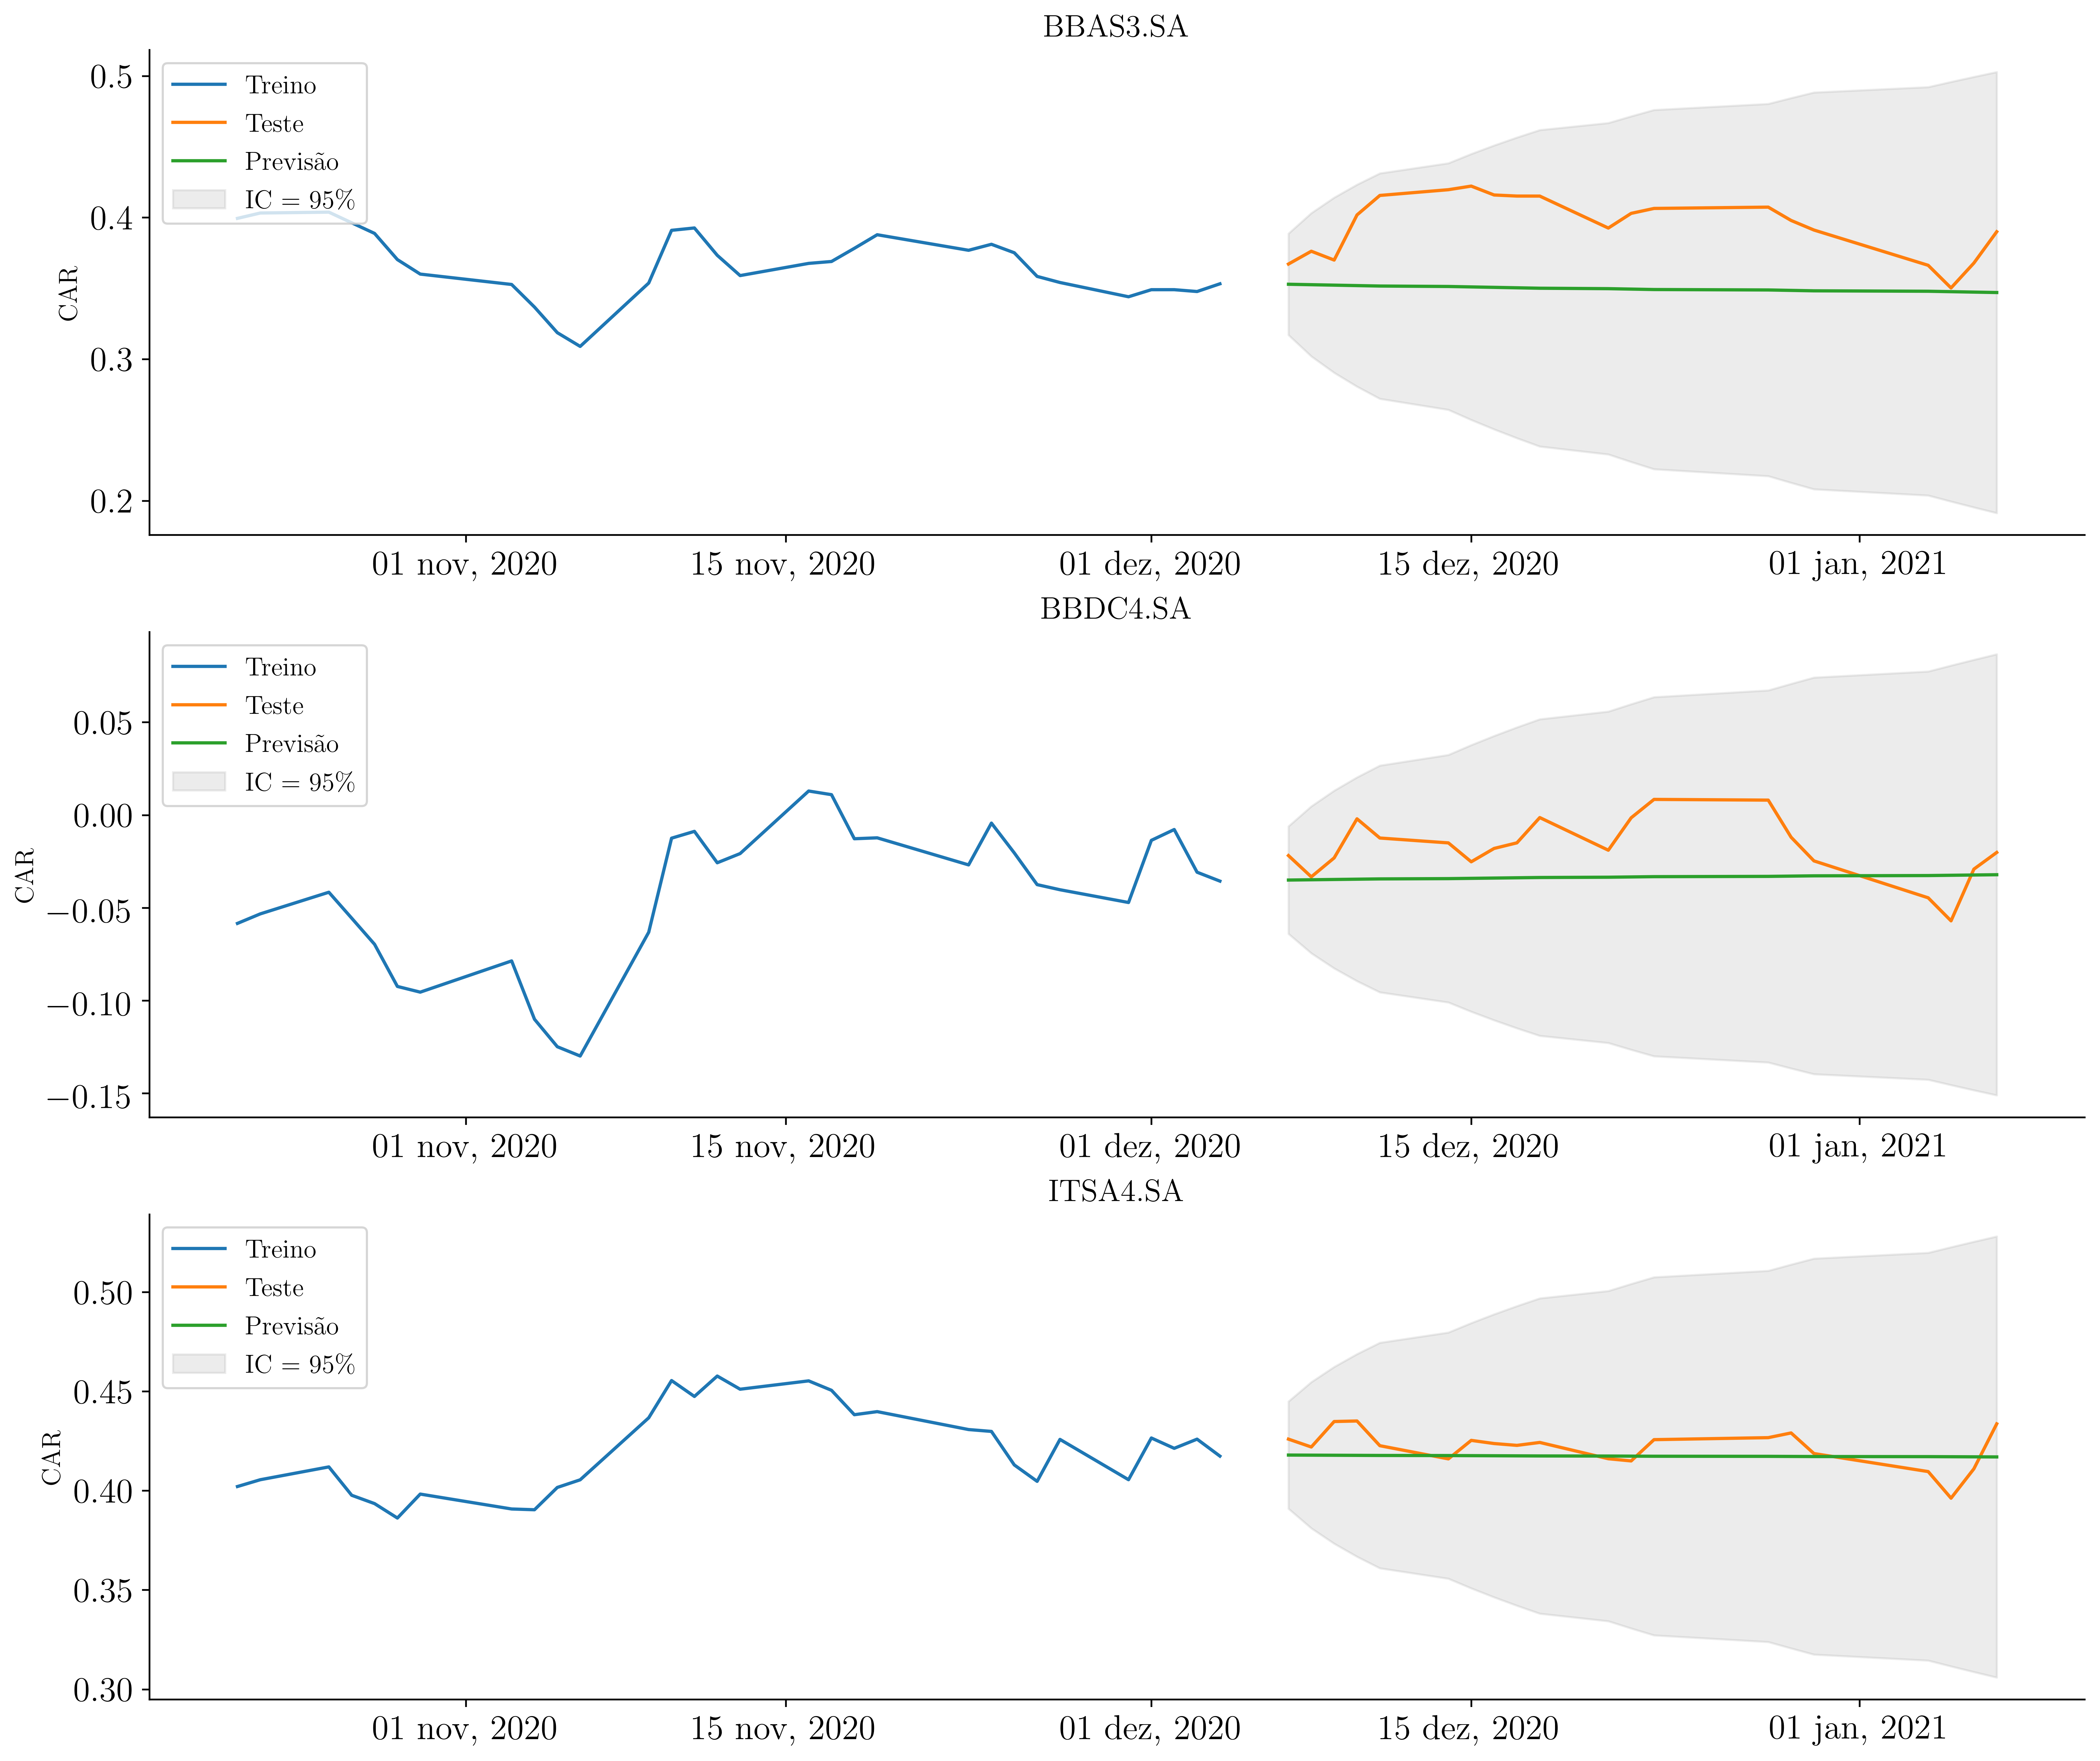

In [16]:
dados.index = vetor_datas
dados.index =pd.DatetimeIndex(dados.index).to_period('D')
fig, ax = plt.subplots(3,1, figsize=[16,14],dpi=500)

ordens=[(1,0,0), (1,0,1), (1,0,1)]

for i in range(3):
    
   
    treino = dados.iloc[:-20, i]
    teste = dados.iloc[-20:, i]

    modelo = ARIMA(treino, order=ordens[i]).fit()
    
    # Forecast
    fc, se, conf = modelo.forecast(20, alpha=0.05)  # 95% conf
    
    treino.index=vetor_datas[:-20]
    teste.index = vetor_datas[-20:]
    
    # Make as pandas series
    fc_series = pd.Series(fc, index=teste.index)
    lower_series = pd.Series(conf[:, 0], index=teste.index)
    upper_series = pd.Series(conf[:, 1], index=teste.index)


    # Plot    
    
    ax[i].plot(treino[-30:], label='Treino')
    ax[i].plot(teste, label='Teste')
    ax[i].plot(fc_series, label='Previsão')
    ax[i].fill_between(lower_series.index, lower_series, upper_series, label='IC = 95\%', 
                 color='gray', alpha=.15)
    ax[i].set_title(empresas[i])
    ax[i].legend(loc='upper left', fontsize=12)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylabel('CAR')
    ax[i].xaxis.set_major_formatter(formato)
    ax[i].tick_params(axis="x", labelsize=16) 
    ax[i].tick_params(axis="y", labelsize=16)
    ax[i].set_xlabel('')
plt.savefig('previsoes.png', 
            dpi=500, 
            bbox_inches='tight',
            pad_inches = 0)


In [9]:
#### STEPWISE
#import pmdarima as pm #pip install pmdarima
#model = pm.auto_arima(dados[empresas[0]], start_p=1, start_q=1,
#                     test='adf',       # use adftest to find optimal 'd'
#                     m=1,              # frequency of series
#                      d=None,           # let model determine 'd'
#                      seasonal=True,   # No Seasonality
#                      start_P=0, 
#                      D=0, 
#                      trace=True,
#                     error_action='ignore',  
#                      suppress_warnings=True, 
#                     stepwise=True)

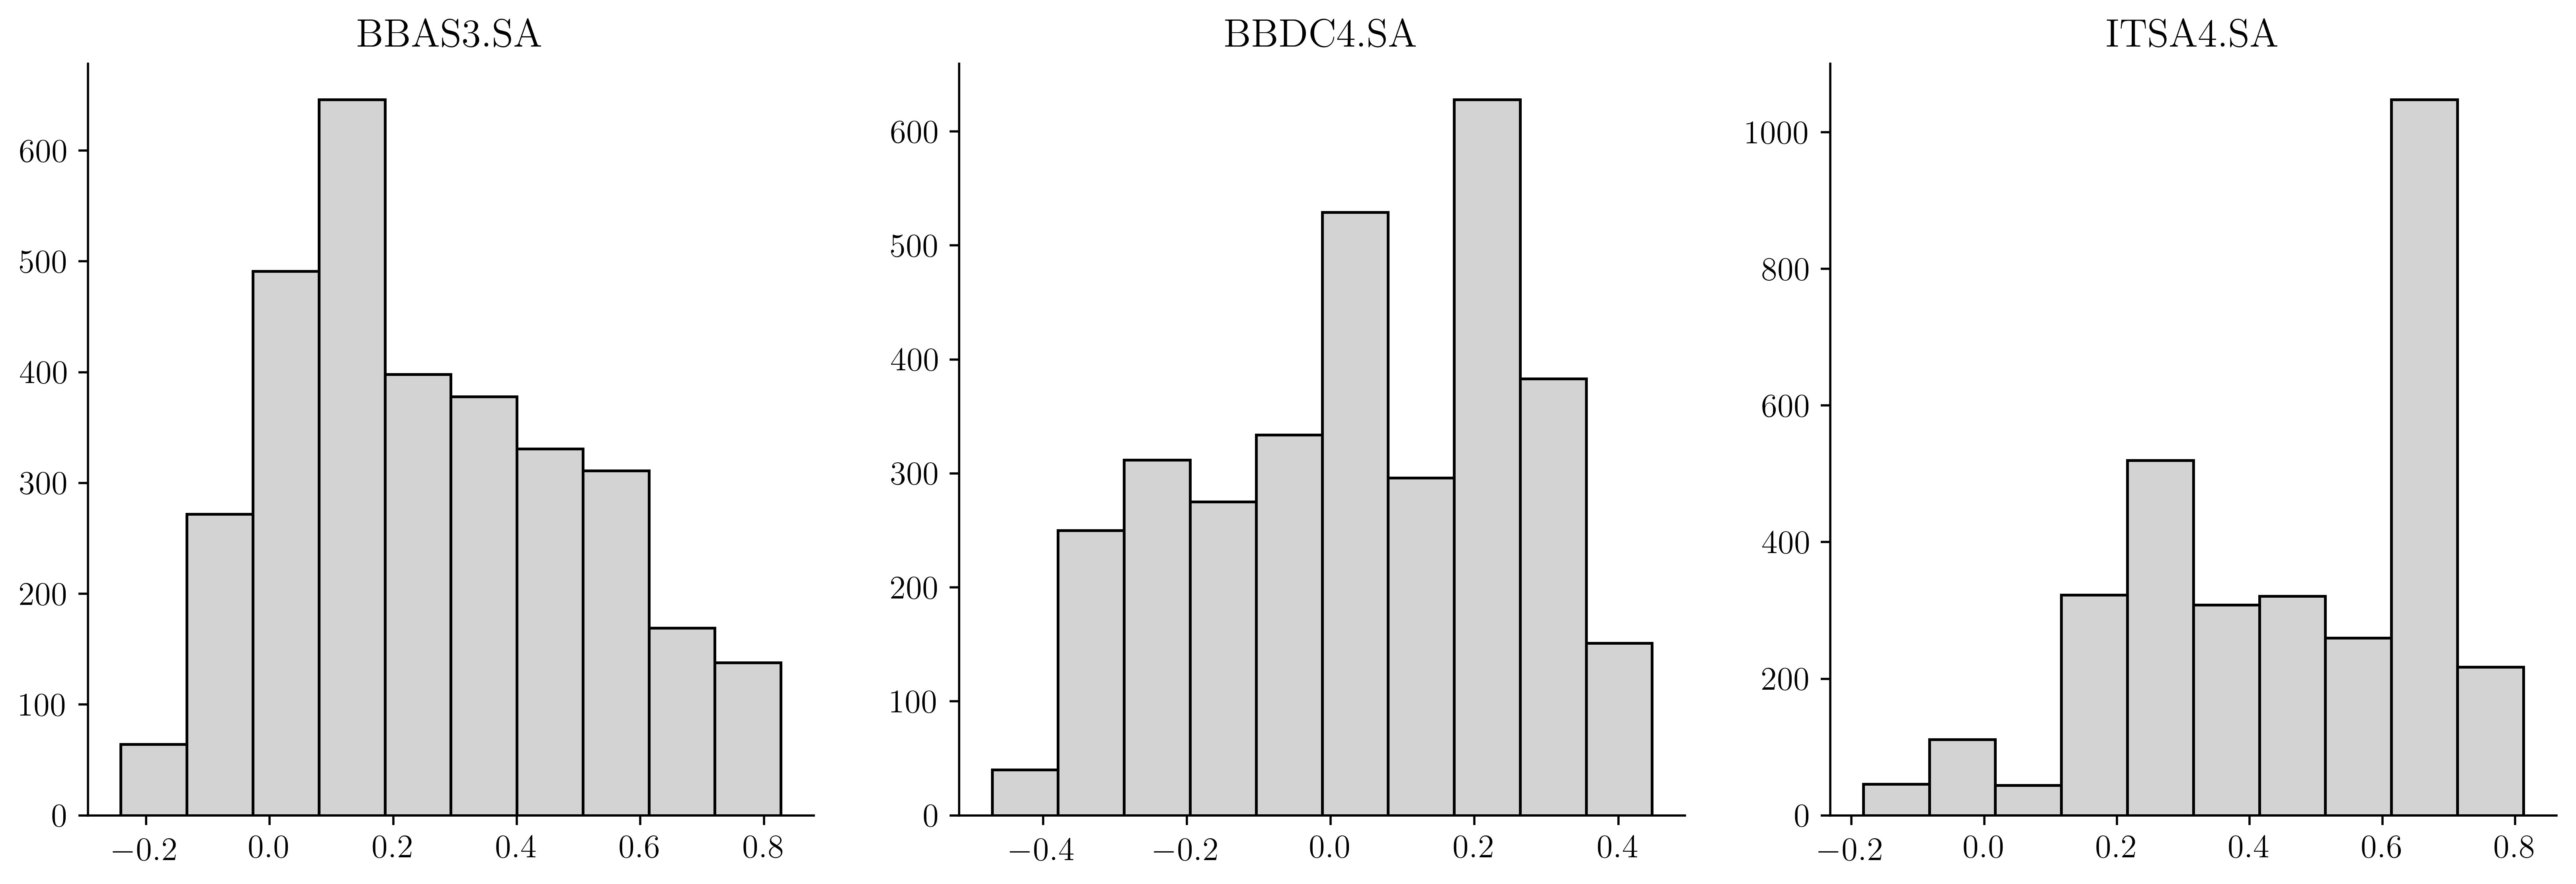

In [39]:
fig, ax = plt.subplots(1,3,figsize=[16,5])

for i in range(3):
    ax[i].hist(dados[empresas[i]], color = 'lightgray', edgecolor='black', label=empresas[i])
    ax[i].set_title(empresas[i]);
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
plt.savefig('dist_retornos.png',
            dpi=500, 
            bbox_inches='tight',
            pad_inches = 0)

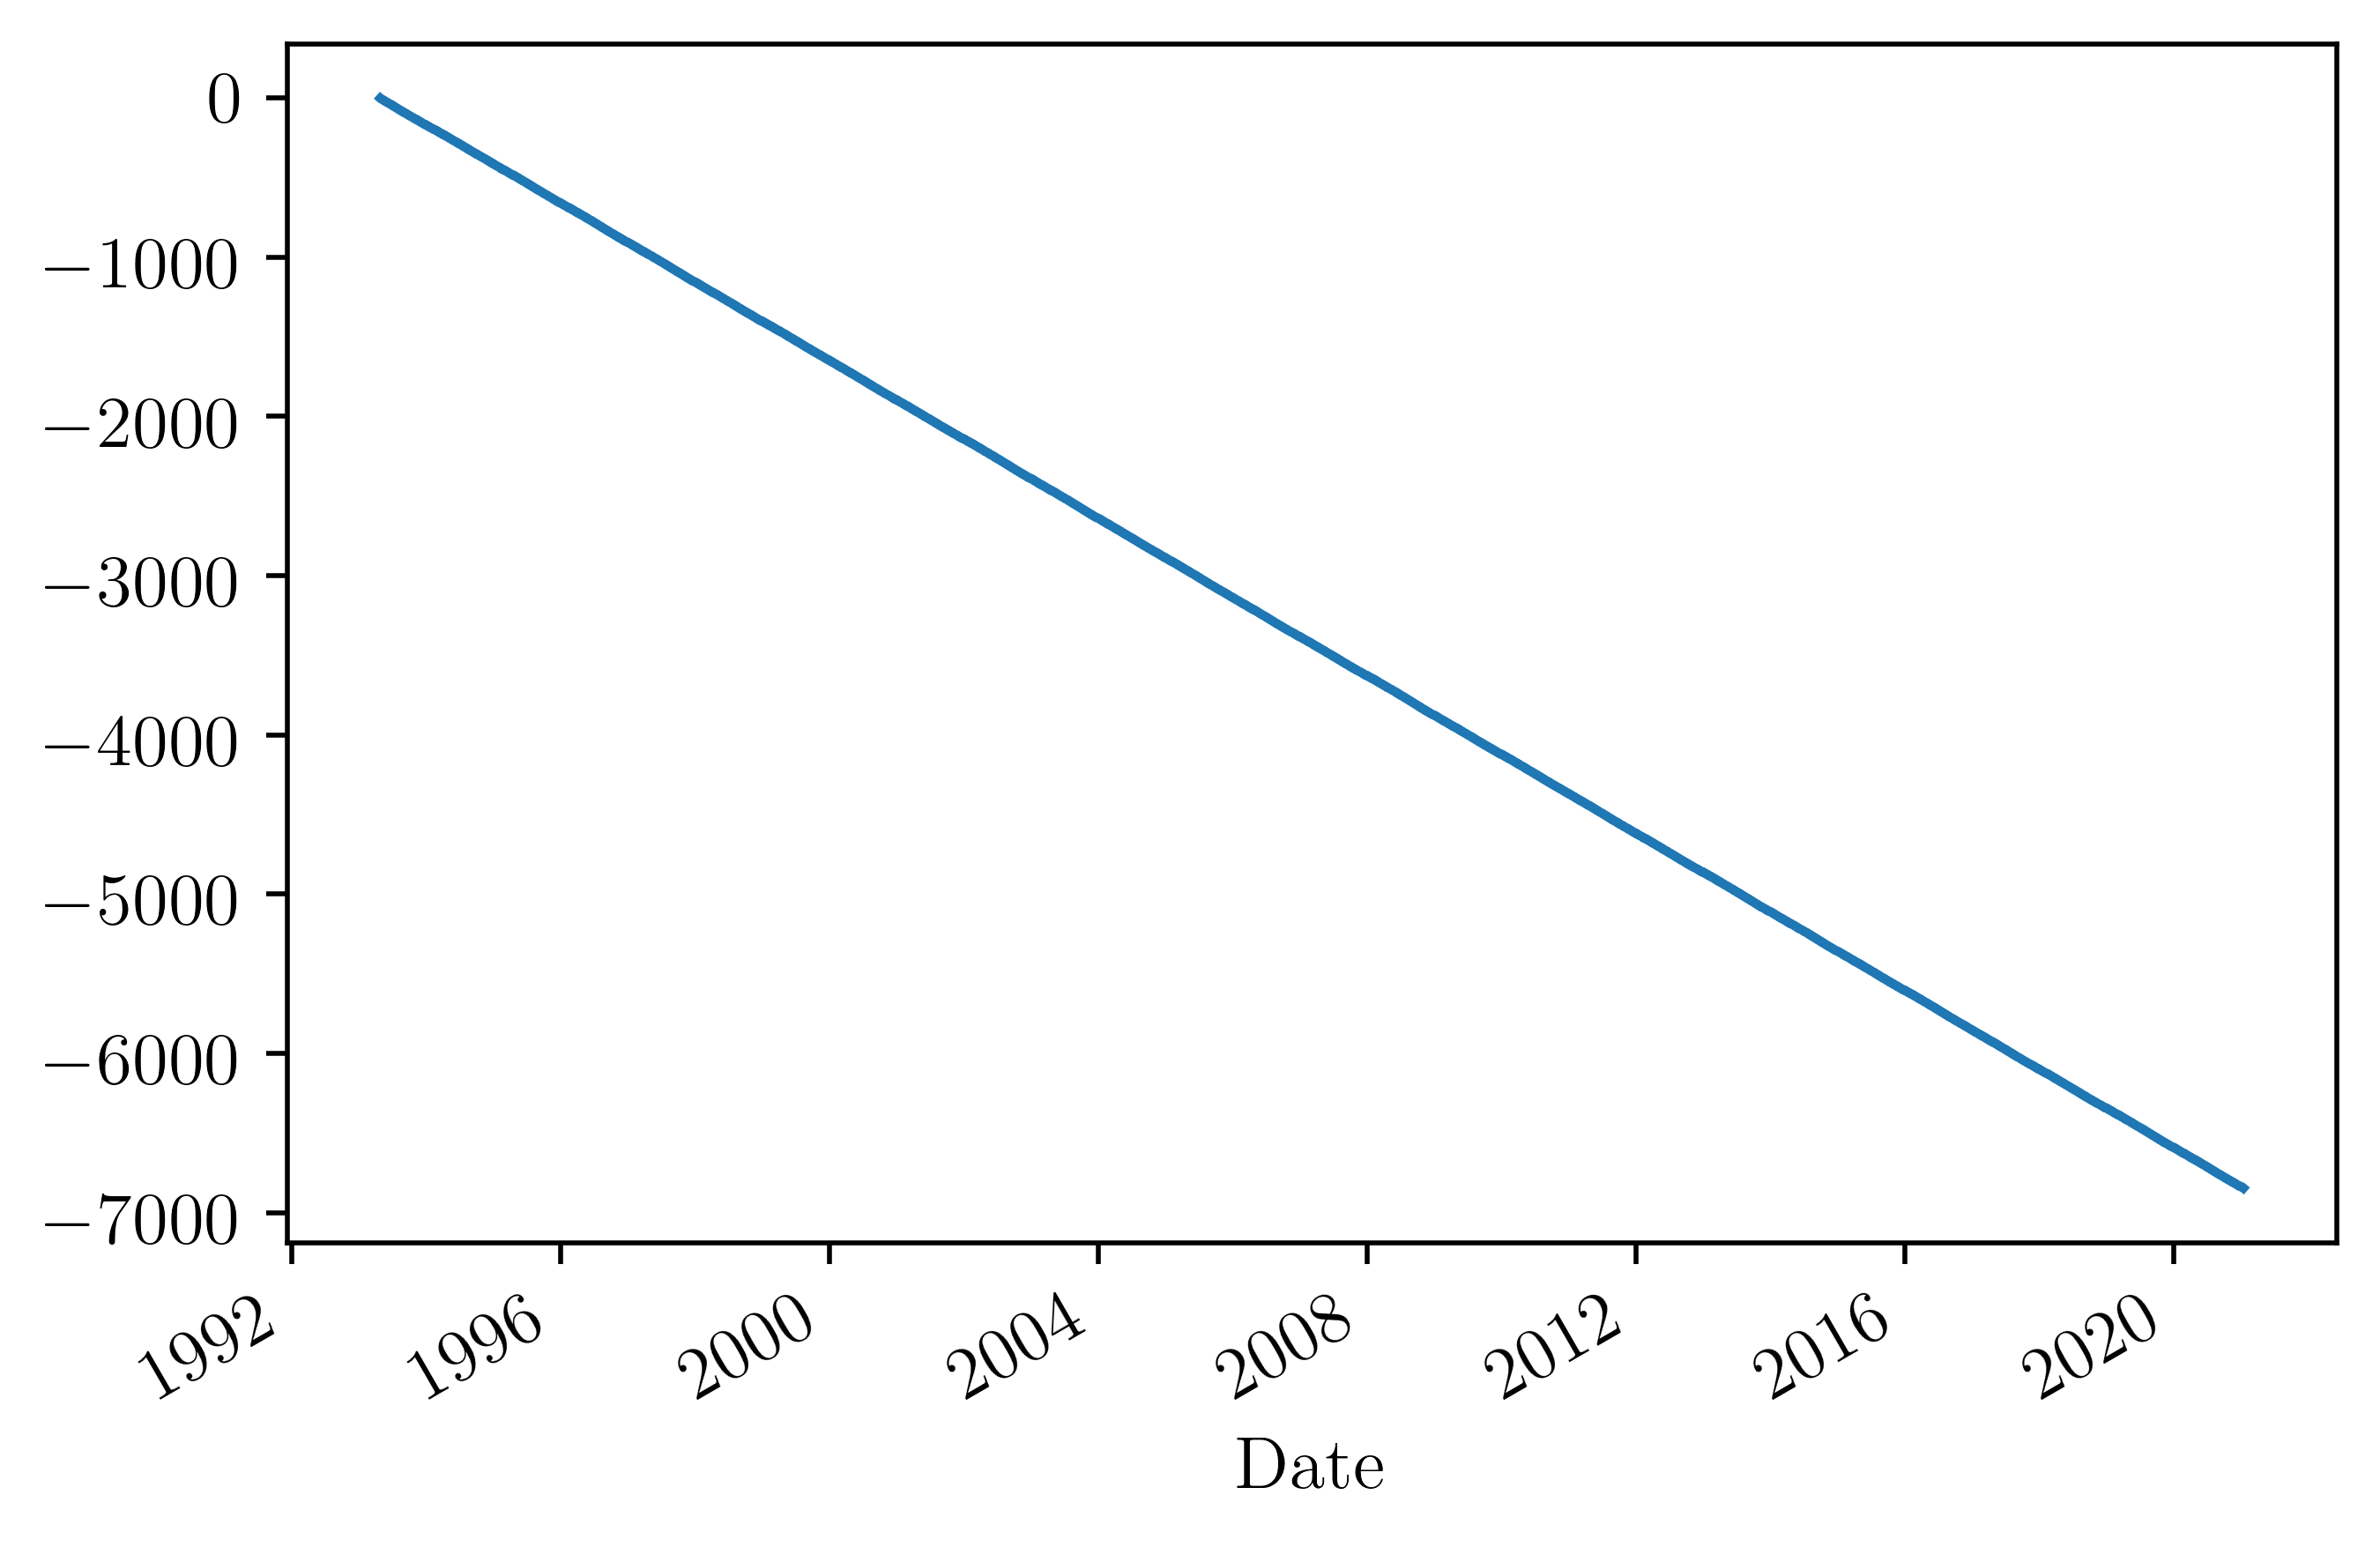

In [52]:
np.cumsum(bovespa['Close'].diff()[1:] / bovespa['Close'][:-1] - 1).plot()

In [48]:
bovespa['Close'][:-1]

Date
1993-04-27        24.500000
1993-04-28        24.299999
1993-04-29        23.700001
1993-04-30        24.100000
1993-05-03        24.100000
                  ...      
2021-01-08    125077.000000
2021-01-11    122807.000000
2021-01-12    123998.000000
2021-01-13    122040.000000
2021-01-14    123481.000000
Name: Close, Length: 6854, dtype: float64